In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import glob
import os
import csv

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import load_model
%matplotlib inline

C:\Users\asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

In [3]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('../Data set/FIXED_SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        moving_average_data = []
        for row in file_data:
            if row[1] is '':
                continue
            elif len(moving_average_data) < 30:
                moving_average_data.append(float(row[1]))
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                ma = np.sum(moving_average_data) / 30
                temp = float(row[1])
                diff_ma = temp - ma
                diff_ma = ["{0:.2f}".format(diff_ma)]
                stock_data.append(diff_ma)
                del moving_average_data[0]
                moving_average_data.append(float(row[1]))
    return stock_data

In [4]:
stock_datas = [ load_stock_data(x, 2008, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

In [5]:
rounds = min_count - 30
train_index = int(rounds * 0.7)

In [6]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_test = x[train_index: train_index+1].astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2] * x_train.shape[3]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2] * x_test.shape[3]))

print(x_train.shape, x_test.shape)

(1788, 36, 30) (119, 36, 30) (1, 36, 30)


In [10]:
target = []
index = 0
while index < rounds:
    temp = [stock[index + 30][0] for stock in stock_datas]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_test = y[train_index: rounds].astype('float32')

print(y_train.shape, y_test.shape)

(1788, 36) (119, 36) (478, 36)


In [11]:
neurons = 512        
activation_function = 'tanh'  
loss = 'mse'                  
optimizer = 'sgd'          
dropout = 0.25                
batch_size = 100       
epochs = 10000              
# window_len = 30                     

In [12]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['acc','mae'])
    model.summary()
    return model

In [13]:
model = build_model(x_train, output_size=36, neurons=neurons)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 36, 512)           1112064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 36, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                18468     
__________

In [14]:
model_history = model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, batch_size = batch_size, verbose= 1)
model.save('LSTM_ma_512_128_5000.h5')

Train on 1788 samples, validate on 119 samples
Epoch 1/5000
1788/1788 [==============================] - 30s 17ms/step - loss: 28.2387 - acc: 0.1549 - mean_squared_error: 28.2387 - val_loss: 49.2991 - val_acc: 0.0420 - val_mean_squared_error: 49.2991
Epoch 2/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 27.3762 - acc: 0.2092 - mean_squared_error: 27.3762 - val_loss: 48.5754 - val_acc: 0.0588 - val_mean_squared_error: 48.5754
Epoch 3/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 26.8680 - acc: 0.2047 - mean_squared_error: 26.8680 - val_loss: 48.2213 - val_acc: 0.0420 - val_mean_squared_error: 48.2213
Epoch 4/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 26.5903 - acc: 0.2030 - mean_squared_error: 26.5903 - val_loss: 48.0008 - val_acc: 0.0588 - val_mean_squared_error: 48.0008
Epoch 5/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 26.4344 - acc: 0.2064 - mean_squared_error: 26.4344 - val_loss: 4

1788/1788 [==============================] - 6s 3ms/step - loss: 25.7208 - acc: 0.2438 - mean_squared_error: 25.7208 - val_loss: 47.1732 - val_acc: 0.0924 - val_mean_squared_error: 47.1732
Epoch 82/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.7189 - acc: 0.2405 - mean_squared_error: 25.7189 - val_loss: 47.1772 - val_acc: 0.0840 - val_mean_squared_error: 47.1772
Epoch 83/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.7144 - acc: 0.2601 - mean_squared_error: 25.7144 - val_loss: 47.1573 - val_acc: 0.0840 - val_mean_squared_error: 47.1573
Epoch 84/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.7138 - acc: 0.2517 - mean_squared_error: 25.7138 - val_loss: 47.1416 - val_acc: 0.1008 - val_mean_squared_error: 47.1416
Epoch 85/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.7055 - acc: 0.2483 - mean_squared_error: 25.7055 - val_loss: 47.1196 - val_acc: 0.0924 - val_mean_squared_error: 47.1196

1788/1788 [==============================] - 6s 3ms/step - loss: 25.5144 - acc: 0.2886 - mean_squared_error: 25.5144 - val_loss: 47.0407 - val_acc: 0.0840 - val_mean_squared_error: 47.0407
Epoch 162/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.4968 - acc: 0.2836 - mean_squared_error: 25.4968 - val_loss: 47.0344 - val_acc: 0.1092 - val_mean_squared_error: 47.0344
Epoch 163/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.4992 - acc: 0.2886 - mean_squared_error: 25.4992 - val_loss: 47.0903 - val_acc: 0.0924 - val_mean_squared_error: 47.0903
Epoch 164/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.5029 - acc: 0.2897 - mean_squared_error: 25.5029 - val_loss: 47.0828 - val_acc: 0.0924 - val_mean_squared_error: 47.0828
Epoch 165/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.4958 - acc: 0.2875 - mean_squared_error: 25.4958 - val_loss: 47.0698 - val_acc: 0.1092 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 25.3436 - acc: 0.2919 - mean_squared_error: 25.3436 - val_loss: 47.0485 - val_acc: 0.1092 - val_mean_squared_error: 47.0485
Epoch 242/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.3449 - acc: 0.2964 - mean_squared_error: 25.3449 - val_loss: 47.1166 - val_acc: 0.1092 - val_mean_squared_error: 47.1166
Epoch 243/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.3544 - acc: 0.2964 - mean_squared_error: 25.3544 - val_loss: 47.0521 - val_acc: 0.1008 - val_mean_squared_error: 47.0521
Epoch 244/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.3641 - acc: 0.2992 - mean_squared_error: 25.3641 - val_loss: 47.1825 - val_acc: 0.1176 - val_mean_squared_error: 47.1825
Epoch 245/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.3516 - acc: 0.2942 - mean_squared_error: 25.3516 - val_loss: 47.1562 - val_acc: 0.1176 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 25.2467 - acc: 0.3126 - mean_squared_error: 25.2467 - val_loss: 46.9734 - val_acc: 0.1681 - val_mean_squared_error: 46.9734
Epoch 322/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.2527 - acc: 0.3043 - mean_squared_error: 25.2527 - val_loss: 47.0743 - val_acc: 0.1681 - val_mean_squared_error: 47.0743
Epoch 323/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.2396 - acc: 0.3037 - mean_squared_error: 25.2396 - val_loss: 47.0598 - val_acc: 0.1597 - val_mean_squared_error: 47.0598
Epoch 324/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.2365 - acc: 0.3132 - mean_squared_error: 25.2365 - val_loss: 47.0810 - val_acc: 0.1597 - val_mean_squared_error: 47.0810
Epoch 325/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.2398 - acc: 0.3166 - mean_squared_error: 25.2398 - val_loss: 47.0311 - val_acc: 0.1765 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 25.1633 - acc: 0.3087 - mean_squared_error: 25.1633 - val_loss: 47.0131 - val_acc: 0.1849 - val_mean_squared_error: 47.0131
Epoch 402/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.1612 - acc: 0.3110 - mean_squared_error: 25.1612 - val_loss: 47.1027 - val_acc: 0.1933 - val_mean_squared_error: 47.1027
Epoch 403/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.1670 - acc: 0.3121 - mean_squared_error: 25.1670 - val_loss: 47.0569 - val_acc: 0.1933 - val_mean_squared_error: 47.0569
Epoch 404/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.1624 - acc: 0.3160 - mean_squared_error: 25.1624 - val_loss: 47.0015 - val_acc: 0.2017 - val_mean_squared_error: 47.0015
Epoch 405/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.1557 - acc: 0.3026 - mean_squared_error: 25.1557 - val_loss: 47.0364 - val_acc: 0.2017 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 25.1073 - acc: 0.3076 - mean_squared_error: 25.1073 - val_loss: 47.1034 - val_acc: 0.2185 - val_mean_squared_error: 47.1034
Epoch 482/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.1004 - acc: 0.3132 - mean_squared_error: 25.1004 - val_loss: 47.0440 - val_acc: 0.1933 - val_mean_squared_error: 47.0440
Epoch 483/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0983 - acc: 0.3110 - mean_squared_error: 25.0983 - val_loss: 47.0513 - val_acc: 0.2185 - val_mean_squared_error: 47.0513
Epoch 484/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0941 - acc: 0.3104 - mean_squared_error: 25.0941 - val_loss: 47.0332 - val_acc: 0.2185 - val_mean_squared_error: 47.0332
Epoch 485/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0917 - acc: 0.3093 - mean_squared_error: 25.0917 - val_loss: 47.0806 - val_acc: 0.2269 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 25.0292 - acc: 0.3177 - mean_squared_error: 25.0292 - val_loss: 47.1148 - val_acc: 0.2269 - val_mean_squared_error: 47.1148
Epoch 562/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0419 - acc: 0.3110 - mean_squared_error: 25.0419 - val_loss: 47.0458 - val_acc: 0.2353 - val_mean_squared_error: 47.0458
Epoch 563/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0412 - acc: 0.3132 - mean_squared_error: 25.0412 - val_loss: 47.0064 - val_acc: 0.2269 - val_mean_squared_error: 47.0064
Epoch 564/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0295 - acc: 0.3233 - mean_squared_error: 25.0295 - val_loss: 47.0513 - val_acc: 0.2437 - val_mean_squared_error: 47.0513
Epoch 565/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 25.0241 - acc: 0.3126 - mean_squared_error: 25.0241 - val_loss: 47.0314 - val_acc: 0.2269 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 24.9729 - acc: 0.3188 - mean_squared_error: 24.9729 - val_loss: 46.9234 - val_acc: 0.2437 - val_mean_squared_error: 46.9234
Epoch 642/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9712 - acc: 0.3283 - mean_squared_error: 24.9712 - val_loss: 46.9718 - val_acc: 0.2185 - val_mean_squared_error: 46.9718
Epoch 643/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9727 - acc: 0.3361 - mean_squared_error: 24.9727 - val_loss: 46.9159 - val_acc: 0.2353 - val_mean_squared_error: 46.9159
Epoch 644/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9744 - acc: 0.3121 - mean_squared_error: 24.9744 - val_loss: 46.8797 - val_acc: 0.2521 - val_mean_squared_error: 46.8797
Epoch 645/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9694 - acc: 0.3300 - mean_squared_error: 24.9694 - val_loss: 46.9236 - val_acc: 0.2353 - val_mean_squared_error: 46.

1788/1788 [==============================] - 6s 3ms/step - loss: 24.9206 - acc: 0.3451 - mean_squared_error: 24.9206 - val_loss: 46.9268 - val_acc: 0.2605 - val_mean_squared_error: 46.9268
Epoch 722/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9204 - acc: 0.3412 - mean_squared_error: 24.9204 - val_loss: 46.9208 - val_acc: 0.2521 - val_mean_squared_error: 46.9208
Epoch 723/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9211 - acc: 0.3372 - mean_squared_error: 24.9211 - val_loss: 46.9262 - val_acc: 0.2605 - val_mean_squared_error: 46.9262
Epoch 724/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9198 - acc: 0.3345 - mean_squared_error: 24.9198 - val_loss: 46.9263 - val_acc: 0.2269 - val_mean_squared_error: 46.9263
Epoch 725/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.9182 - acc: 0.3294 - mean_squared_error: 24.9182 - val_loss: 46.9276 - val_acc: 0.2269 - val_mean_squared_error: 46.

1788/1788 [==============================] - 6s 3ms/step - loss: 24.8729 - acc: 0.3585 - mean_squared_error: 24.8729 - val_loss: 46.9099 - val_acc: 0.2521 - val_mean_squared_error: 46.9099
Epoch 802/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8731 - acc: 0.3451 - mean_squared_error: 24.8731 - val_loss: 46.8824 - val_acc: 0.2605 - val_mean_squared_error: 46.8824
Epoch 803/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8741 - acc: 0.3378 - mean_squared_error: 24.8741 - val_loss: 46.9014 - val_acc: 0.2605 - val_mean_squared_error: 46.9014
Epoch 804/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8716 - acc: 0.3479 - mean_squared_error: 24.8716 - val_loss: 46.9128 - val_acc: 0.2521 - val_mean_squared_error: 46.9128
Epoch 805/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8738 - acc: 0.3412 - mean_squared_error: 24.8738 - val_loss: 46.9046 - val_acc: 0.2605 - val_mean_squared_error: 46.

1788/1788 [==============================] - 6s 3ms/step - loss: 24.8292 - acc: 0.3557 - mean_squared_error: 24.8292 - val_loss: 46.9295 - val_acc: 0.2521 - val_mean_squared_error: 46.9295
Epoch 882/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8310 - acc: 0.3619 - mean_squared_error: 24.8310 - val_loss: 46.9401 - val_acc: 0.2521 - val_mean_squared_error: 46.9401
Epoch 883/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8315 - acc: 0.3507 - mean_squared_error: 24.8315 - val_loss: 46.9076 - val_acc: 0.2521 - val_mean_squared_error: 46.9076
Epoch 884/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8321 - acc: 0.3641 - mean_squared_error: 24.8321 - val_loss: 46.9220 - val_acc: 0.2605 - val_mean_squared_error: 46.9220
Epoch 885/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.8271 - acc: 0.3641 - mean_squared_error: 24.8271 - val_loss: 46.9325 - val_acc: 0.2605 - val_mean_squared_error: 46.

1788/1788 [==============================] - 6s 3ms/step - loss: 24.7808 - acc: 0.3809 - mean_squared_error: 24.7808 - val_loss: 47.0864 - val_acc: 0.2689 - val_mean_squared_error: 47.0864
Epoch 962/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7781 - acc: 0.3641 - mean_squared_error: 24.7781 - val_loss: 47.0037 - val_acc: 0.2857 - val_mean_squared_error: 47.0037
Epoch 963/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7800 - acc: 0.3635 - mean_squared_error: 24.7800 - val_loss: 46.9875 - val_acc: 0.2857 - val_mean_squared_error: 46.9875
Epoch 964/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7808 - acc: 0.3697 - mean_squared_error: 24.7808 - val_loss: 47.0220 - val_acc: 0.2857 - val_mean_squared_error: 47.0220
Epoch 965/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7777 - acc: 0.3613 - mean_squared_error: 24.7777 - val_loss: 47.0410 - val_acc: 0.2857 - val_mean_squared_error: 47.

1788/1788 [==============================] - 6s 3ms/step - loss: 24.7445 - acc: 0.3674 - mean_squared_error: 24.7445 - val_loss: 47.1151 - val_acc: 0.2773 - val_mean_squared_error: 47.1151
Epoch 1042/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7447 - acc: 0.3635 - mean_squared_error: 24.7447 - val_loss: 47.0917 - val_acc: 0.2857 - val_mean_squared_error: 47.0917
Epoch 1043/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7407 - acc: 0.3736 - mean_squared_error: 24.7407 - val_loss: 47.1211 - val_acc: 0.2857 - val_mean_squared_error: 47.1211
Epoch 1044/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7430 - acc: 0.3708 - mean_squared_error: 24.7430 - val_loss: 47.1009 - val_acc: 0.2773 - val_mean_squared_error: 47.1009
Epoch 1045/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7401 - acc: 0.3714 - mean_squared_error: 24.7401 - val_loss: 47.1050 - val_acc: 0.2941 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.7282 - acc: 0.3663 - mean_squared_error: 24.7282 - val_loss: 47.1535 - val_acc: 0.2773 - val_mean_squared_error: 47.1535
Epoch 1082/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7273 - acc: 0.3702 - mean_squared_error: 24.7273 - val_loss: 47.1560 - val_acc: 0.2857 - val_mean_squared_error: 47.1560
Epoch 1083/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7251 - acc: 0.3591 - mean_squared_error: 24.7251 - val_loss: 47.2055 - val_acc: 0.2857 - val_mean_squared_error: 47.2055
Epoch 1084/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7235 - acc: 0.3714 - mean_squared_error: 24.7235 - val_loss: 47.1685 - val_acc: 0.2773 - val_mean_squared_error: 47.1685
Epoch 1085/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7246 - acc: 0.3635 - mean_squared_error: 24.7246 - val_loss: 47.1315 - val_acc: 0.2857 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.7122 - acc: 0.3697 - mean_squared_error: 24.7122 - val_loss: 47.1660 - val_acc: 0.2605 - val_mean_squared_error: 47.1660
Epoch 1122/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7108 - acc: 0.3613 - mean_squared_error: 24.7108 - val_loss: 47.1515 - val_acc: 0.2605 - val_mean_squared_error: 47.1515
Epoch 1123/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7133 - acc: 0.3758 - mean_squared_error: 24.7133 - val_loss: 47.1407 - val_acc: 0.2689 - val_mean_squared_error: 47.1407
Epoch 1124/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7122 - acc: 0.3781 - mean_squared_error: 24.7122 - val_loss: 47.1584 - val_acc: 0.2521 - val_mean_squared_error: 47.1584
Epoch 1125/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7103 - acc: 0.3624 - mean_squared_error: 24.7103 - val_loss: 47.1410 - val_acc: 0.2773 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.7027 - acc: 0.3686 - mean_squared_error: 24.7027 - val_loss: 47.1676 - val_acc: 0.2773 - val_mean_squared_error: 47.1676
Epoch 1162/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7005 - acc: 0.3697 - mean_squared_error: 24.7005 - val_loss: 47.1748 - val_acc: 0.2857 - val_mean_squared_error: 47.1748
Epoch 1163/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7000 - acc: 0.3814 - mean_squared_error: 24.7000 - val_loss: 47.1508 - val_acc: 0.2857 - val_mean_squared_error: 47.1508
Epoch 1164/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6992 - acc: 0.3663 - mean_squared_error: 24.6992 - val_loss: 47.1300 - val_acc: 0.2857 - val_mean_squared_error: 47.1300
Epoch 1165/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7011 - acc: 0.3764 - mean_squared_error: 24.7011 - val_loss: 47.1987 - val_acc: 0.2773 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6921 - acc: 0.3764 - mean_squared_error: 24.6921 - val_loss: 47.1450 - val_acc: 0.2689 - val_mean_squared_error: 47.1450
Epoch 1202/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6936 - acc: 0.3753 - mean_squared_error: 24.6936 - val_loss: 47.1873 - val_acc: 0.2773 - val_mean_squared_error: 47.1873
Epoch 1203/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6923 - acc: 0.3647 - mean_squared_error: 24.6923 - val_loss: 47.1973 - val_acc: 0.2605 - val_mean_squared_error: 47.1973
Epoch 1204/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6898 - acc: 0.3837 - mean_squared_error: 24.6898 - val_loss: 47.2167 - val_acc: 0.2857 - val_mean_squared_error: 47.2167
Epoch 1205/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6925 - acc: 0.3943 - mean_squared_error: 24.6925 - val_loss: 47.1510 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6837 - acc: 0.3770 - mean_squared_error: 24.6837 - val_loss: 47.1656 - val_acc: 0.2857 - val_mean_squared_error: 47.1656
Epoch 1242/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6853 - acc: 0.3820 - mean_squared_error: 24.6853 - val_loss: 47.2026 - val_acc: 0.2857 - val_mean_squared_error: 47.2026
Epoch 1243/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6845 - acc: 0.3798 - mean_squared_error: 24.6845 - val_loss: 47.2008 - val_acc: 0.2857 - val_mean_squared_error: 47.2008
Epoch 1244/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6836 - acc: 0.3859 - mean_squared_error: 24.6836 - val_loss: 47.1301 - val_acc: 0.2857 - val_mean_squared_error: 47.1301
Epoch 1245/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6836 - acc: 0.3775 - mean_squared_error: 24.6836 - val_loss: 47.1889 - val_acc: 0.2857 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6749 - acc: 0.3921 - mean_squared_error: 24.6749 - val_loss: 47.1911 - val_acc: 0.2773 - val_mean_squared_error: 47.1911
Epoch 1282/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6735 - acc: 0.3870 - mean_squared_error: 24.6735 - val_loss: 47.2217 - val_acc: 0.2773 - val_mean_squared_error: 47.2217
Epoch 1283/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6734 - acc: 0.3814 - mean_squared_error: 24.6734 - val_loss: 47.1725 - val_acc: 0.2773 - val_mean_squared_error: 47.1725
Epoch 1284/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6731 - acc: 0.3786 - mean_squared_error: 24.6731 - val_loss: 47.1997 - val_acc: 0.2773 - val_mean_squared_error: 47.1997
Epoch 1285/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6738 - acc: 0.3781 - mean_squared_error: 24.6738 - val_loss: 47.1614 - val_acc: 0.2773 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6665 - acc: 0.3949 - mean_squared_error: 24.6665 - val_loss: 47.1482 - val_acc: 0.2353 - val_mean_squared_error: 47.1482
Epoch 1322/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6679 - acc: 0.3758 - mean_squared_error: 24.6679 - val_loss: 47.2018 - val_acc: 0.2689 - val_mean_squared_error: 47.2018
Epoch 1323/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6671 - acc: 0.3747 - mean_squared_error: 24.6671 - val_loss: 47.1427 - val_acc: 0.2605 - val_mean_squared_error: 47.1427
Epoch 1324/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6663 - acc: 0.3786 - mean_squared_error: 24.6663 - val_loss: 47.1692 - val_acc: 0.2857 - val_mean_squared_error: 47.1692
Epoch 1325/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.7061 - acc: 0.3764 - mean_squared_error: 24.7061 - val_loss: 47.1535 - val_acc: 0.2857 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6668 - acc: 0.3714 - mean_squared_error: 24.6668 - val_loss: 47.1556 - val_acc: 0.2689 - val_mean_squared_error: 47.1556
Epoch 1362/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6593 - acc: 0.3775 - mean_squared_error: 24.6593 - val_loss: 47.1766 - val_acc: 0.2521 - val_mean_squared_error: 47.1766
Epoch 1363/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6579 - acc: 0.3770 - mean_squared_error: 24.6579 - val_loss: 47.2169 - val_acc: 0.2773 - val_mean_squared_error: 47.2169
Epoch 1364/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6619 - acc: 0.3909 - mean_squared_error: 24.6619 - val_loss: 47.1904 - val_acc: 0.2689 - val_mean_squared_error: 47.1904
Epoch 1365/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6601 - acc: 0.3842 - mean_squared_error: 24.6601 - val_loss: 47.2171 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6532 - acc: 0.3960 - mean_squared_error: 24.6532 - val_loss: 47.0943 - val_acc: 0.2437 - val_mean_squared_error: 47.0943
Epoch 1402/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6528 - acc: 0.3898 - mean_squared_error: 24.6528 - val_loss: 47.0791 - val_acc: 0.2689 - val_mean_squared_error: 47.0791
Epoch 1403/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6530 - acc: 0.3993 - mean_squared_error: 24.6530 - val_loss: 47.1129 - val_acc: 0.2521 - val_mean_squared_error: 47.1129
Epoch 1404/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6527 - acc: 0.3798 - mean_squared_error: 24.6527 - val_loss: 47.1268 - val_acc: 0.2941 - val_mean_squared_error: 47.1268
Epoch 1405/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6516 - acc: 0.3954 - mean_squared_error: 24.6516 - val_loss: 47.0887 - val_acc: 0.2521 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6486 - acc: 0.3842 - mean_squared_error: 24.6486 - val_loss: 47.1033 - val_acc: 0.2353 - val_mean_squared_error: 47.1033
Epoch 1442/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6468 - acc: 0.4044 - mean_squared_error: 24.6468 - val_loss: 47.1829 - val_acc: 0.2437 - val_mean_squared_error: 47.1829
Epoch 1443/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6458 - acc: 0.4027 - mean_squared_error: 24.6458 - val_loss: 47.1653 - val_acc: 0.2521 - val_mean_squared_error: 47.1653
Epoch 1444/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6470 - acc: 0.4016 - mean_squared_error: 24.6470 - val_loss: 47.1616 - val_acc: 0.2773 - val_mean_squared_error: 47.1616
Epoch 1445/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6455 - acc: 0.3926 - mean_squared_error: 24.6455 - val_loss: 47.1501 - val_acc: 0.2521 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6404 - acc: 0.3943 - mean_squared_error: 24.6404 - val_loss: 47.1044 - val_acc: 0.2437 - val_mean_squared_error: 47.1044
Epoch 1482/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6401 - acc: 0.3977 - mean_squared_error: 24.6401 - val_loss: 47.1146 - val_acc: 0.2605 - val_mean_squared_error: 47.1146
Epoch 1483/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6417 - acc: 0.3960 - mean_squared_error: 24.6417 - val_loss: 47.1257 - val_acc: 0.2437 - val_mean_squared_error: 47.1257
Epoch 1484/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6413 - acc: 0.3965 - mean_squared_error: 24.6413 - val_loss: 47.1407 - val_acc: 0.2353 - val_mean_squared_error: 47.1407
Epoch 1485/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6401 - acc: 0.4004 - mean_squared_error: 24.6401 - val_loss: 47.1121 - val_acc: 0.2353 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6346 - acc: 0.3887 - mean_squared_error: 24.6346 - val_loss: 47.1506 - val_acc: 0.2689 - val_mean_squared_error: 47.1506
Epoch 1522/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6354 - acc: 0.3932 - mean_squared_error: 24.6354 - val_loss: 47.1065 - val_acc: 0.2773 - val_mean_squared_error: 47.1065
Epoch 1523/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6358 - acc: 0.3965 - mean_squared_error: 24.6358 - val_loss: 47.1262 - val_acc: 0.2773 - val_mean_squared_error: 47.1262
Epoch 1524/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6365 - acc: 0.3932 - mean_squared_error: 24.6365 - val_loss: 47.1156 - val_acc: 0.2773 - val_mean_squared_error: 47.1156
Epoch 1525/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6355 - acc: 0.4004 - mean_squared_error: 24.6355 - val_loss: 47.1570 - val_acc: 0.2605 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6299 - acc: 0.4038 - mean_squared_error: 24.6299 - val_loss: 47.0741 - val_acc: 0.2773 - val_mean_squared_error: 47.0741
Epoch 1562/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6286 - acc: 0.4066 - mean_squared_error: 24.6286 - val_loss: 47.1430 - val_acc: 0.2605 - val_mean_squared_error: 47.1430
Epoch 1563/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6323 - acc: 0.3993 - mean_squared_error: 24.6323 - val_loss: 47.0901 - val_acc: 0.2521 - val_mean_squared_error: 47.0901
Epoch 1564/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6301 - acc: 0.4004 - mean_squared_error: 24.6301 - val_loss: 47.0753 - val_acc: 0.2437 - val_mean_squared_error: 47.0753
Epoch 1565/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6305 - acc: 0.4021 - mean_squared_error: 24.6305 - val_loss: 47.1200 - val_acc: 0.2353 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6261 - acc: 0.4055 - mean_squared_error: 24.6261 - val_loss: 47.1310 - val_acc: 0.2269 - val_mean_squared_error: 47.1310
Epoch 1602/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6241 - acc: 0.4027 - mean_squared_error: 24.6241 - val_loss: 47.1127 - val_acc: 0.2521 - val_mean_squared_error: 47.1127
Epoch 1603/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6237 - acc: 0.3982 - mean_squared_error: 24.6237 - val_loss: 47.1308 - val_acc: 0.2689 - val_mean_squared_error: 47.1308
Epoch 1604/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6240 - acc: 0.3960 - mean_squared_error: 24.6240 - val_loss: 47.1565 - val_acc: 0.2437 - val_mean_squared_error: 47.1565
Epoch 1605/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6240 - acc: 0.4049 - mean_squared_error: 24.6240 - val_loss: 47.1057 - val_acc: 0.2521 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6183 - acc: 0.3960 - mean_squared_error: 24.6183 - val_loss: 47.0583 - val_acc: 0.2773 - val_mean_squared_error: 47.0583
Epoch 1642/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6187 - acc: 0.4004 - mean_squared_error: 24.6187 - val_loss: 47.0945 - val_acc: 0.2605 - val_mean_squared_error: 47.0945
Epoch 1643/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6191 - acc: 0.4060 - mean_squared_error: 24.6191 - val_loss: 47.1358 - val_acc: 0.2605 - val_mean_squared_error: 47.1358
Epoch 1644/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6188 - acc: 0.3988 - mean_squared_error: 24.6188 - val_loss: 47.1462 - val_acc: 0.2437 - val_mean_squared_error: 47.1462
Epoch 1645/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6180 - acc: 0.4100 - mean_squared_error: 24.6180 - val_loss: 47.0954 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6140 - acc: 0.3954 - mean_squared_error: 24.6140 - val_loss: 47.1028 - val_acc: 0.2773 - val_mean_squared_error: 47.1028
Epoch 1682/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6140 - acc: 0.4094 - mean_squared_error: 24.6140 - val_loss: 47.1127 - val_acc: 0.2857 - val_mean_squared_error: 47.1127
Epoch 1683/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6154 - acc: 0.4094 - mean_squared_error: 24.6154 - val_loss: 47.1066 - val_acc: 0.2689 - val_mean_squared_error: 47.1066
Epoch 1684/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6147 - acc: 0.4094 - mean_squared_error: 24.6147 - val_loss: 47.1356 - val_acc: 0.2605 - val_mean_squared_error: 47.1356
Epoch 1685/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6185 - acc: 0.4072 - mean_squared_error: 24.6185 - val_loss: 47.1078 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6112 - acc: 0.4032 - mean_squared_error: 24.6112 - val_loss: 47.1112 - val_acc: 0.2773 - val_mean_squared_error: 47.1112
Epoch 1722/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6104 - acc: 0.4060 - mean_squared_error: 24.6104 - val_loss: 47.0652 - val_acc: 0.2689 - val_mean_squared_error: 47.0652
Epoch 1723/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6099 - acc: 0.4060 - mean_squared_error: 24.6099 - val_loss: 47.0784 - val_acc: 0.2689 - val_mean_squared_error: 47.0784
Epoch 1724/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6101 - acc: 0.4144 - mean_squared_error: 24.6101 - val_loss: 47.0633 - val_acc: 0.2857 - val_mean_squared_error: 47.0633
Epoch 1725/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6098 - acc: 0.4094 - mean_squared_error: 24.6098 - val_loss: 47.0806 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6067 - acc: 0.4004 - mean_squared_error: 24.6067 - val_loss: 47.0496 - val_acc: 0.2605 - val_mean_squared_error: 47.0496
Epoch 1762/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6074 - acc: 0.4032 - mean_squared_error: 24.6074 - val_loss: 47.1012 - val_acc: 0.2689 - val_mean_squared_error: 47.1012
Epoch 1763/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6073 - acc: 0.4133 - mean_squared_error: 24.6073 - val_loss: 47.1092 - val_acc: 0.2521 - val_mean_squared_error: 47.1092
Epoch 1764/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6059 - acc: 0.4139 - mean_squared_error: 24.6059 - val_loss: 47.0616 - val_acc: 0.2689 - val_mean_squared_error: 47.0616
Epoch 1765/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6045 - acc: 0.3999 - mean_squared_error: 24.6045 - val_loss: 47.0868 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.6021 - acc: 0.3960 - mean_squared_error: 24.6021 - val_loss: 47.0492 - val_acc: 0.2773 - val_mean_squared_error: 47.0492
Epoch 1802/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6010 - acc: 0.3982 - mean_squared_error: 24.6010 - val_loss: 47.0338 - val_acc: 0.2773 - val_mean_squared_error: 47.0338
Epoch 1803/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6022 - acc: 0.3988 - mean_squared_error: 24.6022 - val_loss: 47.0866 - val_acc: 0.2941 - val_mean_squared_error: 47.0866
Epoch 1804/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6032 - acc: 0.4105 - mean_squared_error: 24.6032 - val_loss: 47.0790 - val_acc: 0.2857 - val_mean_squared_error: 47.0790
Epoch 1805/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6010 - acc: 0.4066 - mean_squared_error: 24.6010 - val_loss: 47.0373 - val_acc: 0.2857 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5992 - acc: 0.4217 - mean_squared_error: 24.5992 - val_loss: 47.0658 - val_acc: 0.2773 - val_mean_squared_error: 47.0658
Epoch 1842/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5980 - acc: 0.4223 - mean_squared_error: 24.5980 - val_loss: 47.0746 - val_acc: 0.2857 - val_mean_squared_error: 47.0746
Epoch 1843/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5982 - acc: 0.4116 - mean_squared_error: 24.5982 - val_loss: 47.0467 - val_acc: 0.2773 - val_mean_squared_error: 47.0467
Epoch 1844/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5978 - acc: 0.4139 - mean_squared_error: 24.5978 - val_loss: 47.0800 - val_acc: 0.2773 - val_mean_squared_error: 47.0800
Epoch 1845/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5984 - acc: 0.4200 - mean_squared_error: 24.5984 - val_loss: 47.0954 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5935 - acc: 0.4083 - mean_squared_error: 24.5935 - val_loss: 47.1085 - val_acc: 0.2857 - val_mean_squared_error: 47.1085
Epoch 1882/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5941 - acc: 0.4217 - mean_squared_error: 24.5941 - val_loss: 47.0713 - val_acc: 0.2437 - val_mean_squared_error: 47.0713
Epoch 1883/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5949 - acc: 0.4211 - mean_squared_error: 24.5949 - val_loss: 47.0921 - val_acc: 0.2941 - val_mean_squared_error: 47.0921
Epoch 1884/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5940 - acc: 0.4167 - mean_squared_error: 24.5940 - val_loss: 47.1297 - val_acc: 0.2773 - val_mean_squared_error: 47.1297
Epoch 1885/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5936 - acc: 0.4172 - mean_squared_error: 24.5936 - val_loss: 47.0753 - val_acc: 0.2605 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5912 - acc: 0.4150 - mean_squared_error: 24.5912 - val_loss: 47.1001 - val_acc: 0.2689 - val_mean_squared_error: 47.1001
Epoch 1922/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5903 - acc: 0.4346 - mean_squared_error: 24.5903 - val_loss: 47.0502 - val_acc: 0.2689 - val_mean_squared_error: 47.0502
Epoch 1923/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5912 - acc: 0.4122 - mean_squared_error: 24.5912 - val_loss: 47.1024 - val_acc: 0.2773 - val_mean_squared_error: 47.1024
Epoch 1924/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5910 - acc: 0.4133 - mean_squared_error: 24.5910 - val_loss: 47.1049 - val_acc: 0.2605 - val_mean_squared_error: 47.1049
Epoch 1925/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5897 - acc: 0.4133 - mean_squared_error: 24.5897 - val_loss: 47.0803 - val_acc: 0.2689 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5893 - acc: 0.4251 - mean_squared_error: 24.5893 - val_loss: 47.1362 - val_acc: 0.2605 - val_mean_squared_error: 47.1362
Epoch 1962/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5876 - acc: 0.4239 - mean_squared_error: 24.5876 - val_loss: 47.1487 - val_acc: 0.2857 - val_mean_squared_error: 47.1487
Epoch 1963/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5876 - acc: 0.4128 - mean_squared_error: 24.5876 - val_loss: 47.1300 - val_acc: 0.2689 - val_mean_squared_error: 47.1300
Epoch 1964/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5865 - acc: 0.4128 - mean_squared_error: 24.5865 - val_loss: 47.1538 - val_acc: 0.2437 - val_mean_squared_error: 47.1538
Epoch 1965/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.6842 - acc: 0.3971 - mean_squared_error: 24.6842 - val_loss: 47.1365 - val_acc: 0.2353 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5832 - acc: 0.4072 - mean_squared_error: 24.5832 - val_loss: 47.1169 - val_acc: 0.2773 - val_mean_squared_error: 47.1169
Epoch 2002/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5847 - acc: 0.4200 - mean_squared_error: 24.5847 - val_loss: 47.1146 - val_acc: 0.2689 - val_mean_squared_error: 47.1146
Epoch 2003/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5835 - acc: 0.4200 - mean_squared_error: 24.5835 - val_loss: 47.1343 - val_acc: 0.2521 - val_mean_squared_error: 47.1343
Epoch 2004/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5853 - acc: 0.4183 - mean_squared_error: 24.5853 - val_loss: 47.1002 - val_acc: 0.2773 - val_mean_squared_error: 47.1002
Epoch 2005/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5836 - acc: 0.4027 - mean_squared_error: 24.5836 - val_loss: 47.1571 - val_acc: 0.2353 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5813 - acc: 0.4088 - mean_squared_error: 24.5813 - val_loss: 47.1525 - val_acc: 0.2605 - val_mean_squared_error: 47.1525
Epoch 2042/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5807 - acc: 0.4105 - mean_squared_error: 24.5807 - val_loss: 47.1245 - val_acc: 0.2605 - val_mean_squared_error: 47.1245
Epoch 2043/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5812 - acc: 0.4150 - mean_squared_error: 24.5812 - val_loss: 47.1689 - val_acc: 0.2605 - val_mean_squared_error: 47.1689
Epoch 2044/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5823 - acc: 0.3965 - mean_squared_error: 24.5823 - val_loss: 47.1660 - val_acc: 0.2857 - val_mean_squared_error: 47.1660
Epoch 2045/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5796 - acc: 0.4144 - mean_squared_error: 24.5796 - val_loss: 47.1321 - val_acc: 0.2605 - val_mean_squared_error:

1788/1788 [==============================] - 6s 4ms/step - loss: 24.5807 - acc: 0.4167 - mean_squared_error: 24.5807 - val_loss: 47.1412 - val_acc: 0.2269 - val_mean_squared_error: 47.1412
Epoch 2082/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5781 - acc: 0.4189 - mean_squared_error: 24.5781 - val_loss: 47.1371 - val_acc: 0.2353 - val_mean_squared_error: 47.1371
Epoch 2083/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5785 - acc: 0.4122 - mean_squared_error: 24.5785 - val_loss: 47.1714 - val_acc: 0.2605 - val_mean_squared_error: 47.1714
Epoch 2084/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5784 - acc: 0.4083 - mean_squared_error: 24.5784 - val_loss: 47.1664 - val_acc: 0.2437 - val_mean_squared_error: 47.1664
Epoch 2085/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5777 - acc: 0.4111 - mean_squared_error: 24.5777 - val_loss: 47.1398 - val_acc: 0.2605 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5778 - acc: 0.4116 - mean_squared_error: 24.5778 - val_loss: 47.1493 - val_acc: 0.2521 - val_mean_squared_error: 47.1493
Epoch 2122/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5779 - acc: 0.4122 - mean_squared_error: 24.5779 - val_loss: 47.1423 - val_acc: 0.2521 - val_mean_squared_error: 47.1423
Epoch 2123/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5760 - acc: 0.4144 - mean_squared_error: 24.5760 - val_loss: 47.1720 - val_acc: 0.2353 - val_mean_squared_error: 47.1720
Epoch 2124/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5766 - acc: 0.4234 - mean_squared_error: 24.5766 - val_loss: 47.1636 - val_acc: 0.2353 - val_mean_squared_error: 47.1636
Epoch 2125/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5765 - acc: 0.4195 - mean_squared_error: 24.5765 - val_loss: 47.1508 - val_acc: 0.2605 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5743 - acc: 0.4200 - mean_squared_error: 24.5743 - val_loss: 47.1578 - val_acc: 0.2437 - val_mean_squared_error: 47.1578
Epoch 2162/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5742 - acc: 0.4217 - mean_squared_error: 24.5742 - val_loss: 47.1406 - val_acc: 0.2437 - val_mean_squared_error: 47.1406
Epoch 2163/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5749 - acc: 0.4239 - mean_squared_error: 24.5749 - val_loss: 47.1515 - val_acc: 0.2521 - val_mean_squared_error: 47.1515
Epoch 2164/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5743 - acc: 0.4256 - mean_squared_error: 24.5743 - val_loss: 47.1637 - val_acc: 0.2269 - val_mean_squared_error: 47.1637
Epoch 2165/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5741 - acc: 0.4083 - mean_squared_error: 24.5741 - val_loss: 47.1832 - val_acc: 0.2521 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5711 - acc: 0.4055 - mean_squared_error: 24.5711 - val_loss: 47.1554 - val_acc: 0.2185 - val_mean_squared_error: 47.1554
Epoch 2202/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5730 - acc: 0.4200 - mean_squared_error: 24.5730 - val_loss: 47.1835 - val_acc: 0.2269 - val_mean_squared_error: 47.1835
Epoch 2203/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5721 - acc: 0.4245 - mean_squared_error: 24.5721 - val_loss: 47.1951 - val_acc: 0.2353 - val_mean_squared_error: 47.1951
Epoch 2204/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5736 - acc: 0.4144 - mean_squared_error: 24.5736 - val_loss: 47.1669 - val_acc: 0.2185 - val_mean_squared_error: 47.1669
Epoch 2205/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5714 - acc: 0.4200 - mean_squared_error: 24.5714 - val_loss: 47.1469 - val_acc: 0.2437 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5709 - acc: 0.4150 - mean_squared_error: 24.5709 - val_loss: 47.1933 - val_acc: 0.2353 - val_mean_squared_error: 47.1933
Epoch 2242/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5697 - acc: 0.4122 - mean_squared_error: 24.5697 - val_loss: 47.1653 - val_acc: 0.2269 - val_mean_squared_error: 47.1653
Epoch 2243/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5701 - acc: 0.4340 - mean_squared_error: 24.5701 - val_loss: 47.1688 - val_acc: 0.2521 - val_mean_squared_error: 47.1688
Epoch 2244/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5692 - acc: 0.4200 - mean_squared_error: 24.5692 - val_loss: 47.1684 - val_acc: 0.2269 - val_mean_squared_error: 47.1684
Epoch 2245/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5691 - acc: 0.4228 - mean_squared_error: 24.5691 - val_loss: 47.1718 - val_acc: 0.2521 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5673 - acc: 0.4155 - mean_squared_error: 24.5673 - val_loss: 47.1860 - val_acc: 0.2269 - val_mean_squared_error: 47.1860
Epoch 2282/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5676 - acc: 0.4172 - mean_squared_error: 24.5676 - val_loss: 47.1958 - val_acc: 0.2269 - val_mean_squared_error: 47.1958
Epoch 2283/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5673 - acc: 0.4139 - mean_squared_error: 24.5673 - val_loss: 47.2205 - val_acc: 0.2353 - val_mean_squared_error: 47.2205
Epoch 2284/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5671 - acc: 0.4200 - mean_squared_error: 24.5671 - val_loss: 47.1784 - val_acc: 0.2185 - val_mean_squared_error: 47.1784
Epoch 2285/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5667 - acc: 0.4206 - mean_squared_error: 24.5667 - val_loss: 47.1657 - val_acc: 0.2269 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5661 - acc: 0.4116 - mean_squared_error: 24.5661 - val_loss: 47.2070 - val_acc: 0.2437 - val_mean_squared_error: 47.2070
Epoch 2322/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5664 - acc: 0.4262 - mean_squared_error: 24.5664 - val_loss: 47.2073 - val_acc: 0.2353 - val_mean_squared_error: 47.2073
Epoch 2323/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5656 - acc: 0.4189 - mean_squared_error: 24.5656 - val_loss: 47.2012 - val_acc: 0.2353 - val_mean_squared_error: 47.2012
Epoch 2324/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5664 - acc: 0.4195 - mean_squared_error: 24.5664 - val_loss: 47.2078 - val_acc: 0.2437 - val_mean_squared_error: 47.2078
Epoch 2325/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5653 - acc: 0.4167 - mean_squared_error: 24.5653 - val_loss: 47.1916 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5641 - acc: 0.4172 - mean_squared_error: 24.5641 - val_loss: 47.2331 - val_acc: 0.2269 - val_mean_squared_error: 47.2331
Epoch 2362/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5642 - acc: 0.4167 - mean_squared_error: 24.5642 - val_loss: 47.2742 - val_acc: 0.2269 - val_mean_squared_error: 47.2742
Epoch 2363/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5650 - acc: 0.4133 - mean_squared_error: 24.5650 - val_loss: 47.2375 - val_acc: 0.2269 - val_mean_squared_error: 47.2375
Epoch 2364/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5641 - acc: 0.4167 - mean_squared_error: 24.5641 - val_loss: 47.3167 - val_acc: 0.2353 - val_mean_squared_error: 47.3167
Epoch 2365/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5639 - acc: 0.4251 - mean_squared_error: 24.5639 - val_loss: 47.2279 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5622 - acc: 0.4094 - mean_squared_error: 24.5622 - val_loss: 47.2272 - val_acc: 0.2185 - val_mean_squared_error: 47.2272
Epoch 2402/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5622 - acc: 0.4206 - mean_squared_error: 24.5622 - val_loss: 47.2318 - val_acc: 0.2101 - val_mean_squared_error: 47.2318
Epoch 2403/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5612 - acc: 0.4245 - mean_squared_error: 24.5612 - val_loss: 47.2378 - val_acc: 0.2101 - val_mean_squared_error: 47.2378
Epoch 2404/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5615 - acc: 0.4200 - mean_squared_error: 24.5615 - val_loss: 47.2113 - val_acc: 0.2101 - val_mean_squared_error: 47.2113
Epoch 2405/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5621 - acc: 0.4178 - mean_squared_error: 24.5621 - val_loss: 47.2080 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5612 - acc: 0.4189 - mean_squared_error: 24.5612 - val_loss: 47.2085 - val_acc: 0.2101 - val_mean_squared_error: 47.2085
Epoch 2442/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5592 - acc: 0.4290 - mean_squared_error: 24.5592 - val_loss: 47.2056 - val_acc: 0.2101 - val_mean_squared_error: 47.2056
Epoch 2443/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5590 - acc: 0.4077 - mean_squared_error: 24.5590 - val_loss: 47.1894 - val_acc: 0.2269 - val_mean_squared_error: 47.1894
Epoch 2444/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5590 - acc: 0.4161 - mean_squared_error: 24.5590 - val_loss: 47.2196 - val_acc: 0.2185 - val_mean_squared_error: 47.2196
Epoch 2445/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5600 - acc: 0.4251 - mean_squared_error: 24.5600 - val_loss: 47.2079 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5576 - acc: 0.4083 - mean_squared_error: 24.5576 - val_loss: 47.2196 - val_acc: 0.2101 - val_mean_squared_error: 47.2196
Epoch 2482/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5587 - acc: 0.4200 - mean_squared_error: 24.5587 - val_loss: 47.2168 - val_acc: 0.2269 - val_mean_squared_error: 47.2168
Epoch 2483/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5571 - acc: 0.4211 - mean_squared_error: 24.5571 - val_loss: 47.2063 - val_acc: 0.2269 - val_mean_squared_error: 47.2063
Epoch 2484/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5575 - acc: 0.4256 - mean_squared_error: 24.5575 - val_loss: 47.1946 - val_acc: 0.2437 - val_mean_squared_error: 47.1946
Epoch 2485/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5576 - acc: 0.4195 - mean_squared_error: 24.5576 - val_loss: 47.2161 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5555 - acc: 0.4234 - mean_squared_error: 24.5555 - val_loss: 47.2426 - val_acc: 0.2269 - val_mean_squared_error: 47.2426
Epoch 2522/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5562 - acc: 0.4195 - mean_squared_error: 24.5562 - val_loss: 47.2628 - val_acc: 0.2101 - val_mean_squared_error: 47.2628
Epoch 2523/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5559 - acc: 0.4239 - mean_squared_error: 24.5559 - val_loss: 47.2637 - val_acc: 0.2101 - val_mean_squared_error: 47.2637
Epoch 2524/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5548 - acc: 0.4295 - mean_squared_error: 24.5548 - val_loss: 47.2140 - val_acc: 0.2101 - val_mean_squared_error: 47.2140
Epoch 2525/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5557 - acc: 0.4189 - mean_squared_error: 24.5557 - val_loss: 47.2125 - val_acc: 0.2269 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5555 - acc: 0.4346 - mean_squared_error: 24.5555 - val_loss: 47.2276 - val_acc: 0.2185 - val_mean_squared_error: 47.2276
Epoch 2562/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5535 - acc: 0.4279 - mean_squared_error: 24.5535 - val_loss: 47.2498 - val_acc: 0.2101 - val_mean_squared_error: 47.2498
Epoch 2563/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5539 - acc: 0.4217 - mean_squared_error: 24.5539 - val_loss: 47.2742 - val_acc: 0.2185 - val_mean_squared_error: 47.2742
Epoch 2564/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5537 - acc: 0.4200 - mean_squared_error: 24.5537 - val_loss: 47.2596 - val_acc: 0.2101 - val_mean_squared_error: 47.2596
Epoch 2565/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5530 - acc: 0.4323 - mean_squared_error: 24.5530 - val_loss: 47.2389 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5527 - acc: 0.4295 - mean_squared_error: 24.5527 - val_loss: 47.2247 - val_acc: 0.2101 - val_mean_squared_error: 47.2247
Epoch 2602/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5526 - acc: 0.4195 - mean_squared_error: 24.5526 - val_loss: 47.2496 - val_acc: 0.2101 - val_mean_squared_error: 47.2496
Epoch 2603/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5526 - acc: 0.4206 - mean_squared_error: 24.5526 - val_loss: 47.2543 - val_acc: 0.2185 - val_mean_squared_error: 47.2543
Epoch 2604/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5525 - acc: 0.4200 - mean_squared_error: 24.5525 - val_loss: 47.2538 - val_acc: 0.2101 - val_mean_squared_error: 47.2538
Epoch 2605/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5515 - acc: 0.4211 - mean_squared_error: 24.5515 - val_loss: 47.2652 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5504 - acc: 0.4279 - mean_squared_error: 24.5504 - val_loss: 47.2224 - val_acc: 0.2101 - val_mean_squared_error: 47.2224
Epoch 2642/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5499 - acc: 0.4189 - mean_squared_error: 24.5499 - val_loss: 47.2237 - val_acc: 0.2269 - val_mean_squared_error: 47.2237
Epoch 2643/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5506 - acc: 0.4262 - mean_squared_error: 24.5506 - val_loss: 47.2434 - val_acc: 0.2185 - val_mean_squared_error: 47.2434
Epoch 2644/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5506 - acc: 0.4251 - mean_squared_error: 24.5506 - val_loss: 47.2606 - val_acc: 0.2185 - val_mean_squared_error: 47.2606
Epoch 2645/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5500 - acc: 0.4139 - mean_squared_error: 24.5500 - val_loss: 47.2498 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5497 - acc: 0.4340 - mean_squared_error: 24.5497 - val_loss: 47.3139 - val_acc: 0.2101 - val_mean_squared_error: 47.3139
Epoch 2682/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5482 - acc: 0.4273 - mean_squared_error: 24.5482 - val_loss: 47.2708 - val_acc: 0.2017 - val_mean_squared_error: 47.2708
Epoch 2683/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5486 - acc: 0.4279 - mean_squared_error: 24.5486 - val_loss: 47.2428 - val_acc: 0.2017 - val_mean_squared_error: 47.2428
Epoch 2684/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5489 - acc: 0.4088 - mean_squared_error: 24.5489 - val_loss: 47.2592 - val_acc: 0.2101 - val_mean_squared_error: 47.2592
Epoch 2685/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5494 - acc: 0.4368 - mean_squared_error: 24.5494 - val_loss: 47.2455 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5477 - acc: 0.4262 - mean_squared_error: 24.5477 - val_loss: 47.2709 - val_acc: 0.2101 - val_mean_squared_error: 47.2709
Epoch 2722/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5476 - acc: 0.4217 - mean_squared_error: 24.5476 - val_loss: 47.2724 - val_acc: 0.2017 - val_mean_squared_error: 47.2724
Epoch 2723/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5471 - acc: 0.4161 - mean_squared_error: 24.5471 - val_loss: 47.2555 - val_acc: 0.2101 - val_mean_squared_error: 47.2555
Epoch 2724/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5476 - acc: 0.4245 - mean_squared_error: 24.5476 - val_loss: 47.2162 - val_acc: 0.2185 - val_mean_squared_error: 47.2162
Epoch 2725/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5476 - acc: 0.4200 - mean_squared_error: 24.5476 - val_loss: 47.2256 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5499 - acc: 0.4195 - mean_squared_error: 24.5499 - val_loss: 47.2838 - val_acc: 0.2101 - val_mean_squared_error: 47.2838
Epoch 2762/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5463 - acc: 0.4139 - mean_squared_error: 24.5463 - val_loss: 47.2745 - val_acc: 0.2017 - val_mean_squared_error: 47.2745
Epoch 2763/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5461 - acc: 0.4239 - mean_squared_error: 24.5461 - val_loss: 47.2992 - val_acc: 0.2185 - val_mean_squared_error: 47.2992
Epoch 2764/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5465 - acc: 0.4172 - mean_squared_error: 24.5465 - val_loss: 47.2985 - val_acc: 0.2185 - val_mean_squared_error: 47.2985
Epoch 2765/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5473 - acc: 0.4178 - mean_squared_error: 24.5473 - val_loss: 47.2560 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5453 - acc: 0.4323 - mean_squared_error: 24.5453 - val_loss: 47.2947 - val_acc: 0.2185 - val_mean_squared_error: 47.2947
Epoch 2802/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5458 - acc: 0.4329 - mean_squared_error: 24.5458 - val_loss: 47.2589 - val_acc: 0.2101 - val_mean_squared_error: 47.2589
Epoch 2803/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5461 - acc: 0.4284 - mean_squared_error: 24.5461 - val_loss: 47.2771 - val_acc: 0.2185 - val_mean_squared_error: 47.2771
Epoch 2804/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5459 - acc: 0.4195 - mean_squared_error: 24.5459 - val_loss: 47.2218 - val_acc: 0.2185 - val_mean_squared_error: 47.2218
Epoch 2805/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5453 - acc: 0.4256 - mean_squared_error: 24.5453 - val_loss: 47.2925 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5435 - acc: 0.4228 - mean_squared_error: 24.5435 - val_loss: 47.3173 - val_acc: 0.2185 - val_mean_squared_error: 47.3173
Epoch 2842/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5445 - acc: 0.4290 - mean_squared_error: 24.5445 - val_loss: 47.2988 - val_acc: 0.2101 - val_mean_squared_error: 47.2988
Epoch 2843/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5443 - acc: 0.4155 - mean_squared_error: 24.5443 - val_loss: 47.2663 - val_acc: 0.2101 - val_mean_squared_error: 47.2663
Epoch 2844/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5445 - acc: 0.4318 - mean_squared_error: 24.5445 - val_loss: 47.2926 - val_acc: 0.2101 - val_mean_squared_error: 47.2926
Epoch 2845/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5443 - acc: 0.4262 - mean_squared_error: 24.5443 - val_loss: 47.2863 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5435 - acc: 0.4183 - mean_squared_error: 24.5435 - val_loss: 47.2952 - val_acc: 0.2185 - val_mean_squared_error: 47.2952
Epoch 2882/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5436 - acc: 0.4334 - mean_squared_error: 24.5436 - val_loss: 47.2811 - val_acc: 0.2101 - val_mean_squared_error: 47.2811
Epoch 2883/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5439 - acc: 0.4217 - mean_squared_error: 24.5439 - val_loss: 47.3081 - val_acc: 0.2353 - val_mean_squared_error: 47.3081
Epoch 2884/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5435 - acc: 0.4284 - mean_squared_error: 24.5435 - val_loss: 47.2871 - val_acc: 0.2185 - val_mean_squared_error: 47.2871
Epoch 2885/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5432 - acc: 0.4133 - mean_squared_error: 24.5432 - val_loss: 47.2544 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5426 - acc: 0.4346 - mean_squared_error: 24.5426 - val_loss: 47.2728 - val_acc: 0.2101 - val_mean_squared_error: 47.2728
Epoch 2922/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5424 - acc: 0.4256 - mean_squared_error: 24.5424 - val_loss: 47.2619 - val_acc: 0.2185 - val_mean_squared_error: 47.2619
Epoch 2923/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5418 - acc: 0.4133 - mean_squared_error: 24.5418 - val_loss: 47.2519 - val_acc: 0.2185 - val_mean_squared_error: 47.2519
Epoch 2924/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5425 - acc: 0.4256 - mean_squared_error: 24.5425 - val_loss: 47.2642 - val_acc: 0.2185 - val_mean_squared_error: 47.2642
Epoch 2925/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5420 - acc: 0.4256 - mean_squared_error: 24.5420 - val_loss: 47.2675 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5407 - acc: 0.4200 - mean_squared_error: 24.5407 - val_loss: 47.2974 - val_acc: 0.2185 - val_mean_squared_error: 47.2974
Epoch 2962/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5417 - acc: 0.4189 - mean_squared_error: 24.5417 - val_loss: 47.2516 - val_acc: 0.2017 - val_mean_squared_error: 47.2516
Epoch 2963/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5409 - acc: 0.4390 - mean_squared_error: 24.5409 - val_loss: 47.2972 - val_acc: 0.2353 - val_mean_squared_error: 47.2972
Epoch 2964/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5421 - acc: 0.4211 - mean_squared_error: 24.5421 - val_loss: 47.2725 - val_acc: 0.2101 - val_mean_squared_error: 47.2725
Epoch 2965/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5408 - acc: 0.4111 - mean_squared_error: 24.5408 - val_loss: 47.2394 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5400 - acc: 0.4167 - mean_squared_error: 24.5400 - val_loss: 47.2797 - val_acc: 0.2185 - val_mean_squared_error: 47.2797
Epoch 3002/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5402 - acc: 0.4284 - mean_squared_error: 24.5402 - val_loss: 47.3000 - val_acc: 0.2185 - val_mean_squared_error: 47.3000
Epoch 3003/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5403 - acc: 0.4195 - mean_squared_error: 24.5403 - val_loss: 47.3133 - val_acc: 0.2101 - val_mean_squared_error: 47.3133
Epoch 3004/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5394 - acc: 0.4251 - mean_squared_error: 24.5394 - val_loss: 47.2996 - val_acc: 0.2185 - val_mean_squared_error: 47.2996
Epoch 3005/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5397 - acc: 0.4049 - mean_squared_error: 24.5397 - val_loss: 47.2999 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5392 - acc: 0.4195 - mean_squared_error: 24.5392 - val_loss: 47.2888 - val_acc: 0.2101 - val_mean_squared_error: 47.2888
Epoch 3042/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5386 - acc: 0.4150 - mean_squared_error: 24.5386 - val_loss: 47.3040 - val_acc: 0.2101 - val_mean_squared_error: 47.3040
Epoch 3043/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5387 - acc: 0.4374 - mean_squared_error: 24.5387 - val_loss: 47.3218 - val_acc: 0.2101 - val_mean_squared_error: 47.3218
Epoch 3044/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5397 - acc: 0.4273 - mean_squared_error: 24.5397 - val_loss: 47.2882 - val_acc: 0.2185 - val_mean_squared_error: 47.2882
Epoch 3045/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5388 - acc: 0.4228 - mean_squared_error: 24.5388 - val_loss: 47.2886 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5389 - acc: 0.4245 - mean_squared_error: 24.5389 - val_loss: 47.3200 - val_acc: 0.2101 - val_mean_squared_error: 47.3200
Epoch 3082/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5377 - acc: 0.4172 - mean_squared_error: 24.5377 - val_loss: 47.3263 - val_acc: 0.2101 - val_mean_squared_error: 47.3263
Epoch 3083/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5383 - acc: 0.4424 - mean_squared_error: 24.5383 - val_loss: 47.3084 - val_acc: 0.2101 - val_mean_squared_error: 47.3084
Epoch 3084/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5383 - acc: 0.4329 - mean_squared_error: 24.5383 - val_loss: 47.2774 - val_acc: 0.2269 - val_mean_squared_error: 47.2774
Epoch 3085/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5378 - acc: 0.4430 - mean_squared_error: 24.5378 - val_loss: 47.2809 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5371 - acc: 0.4172 - mean_squared_error: 24.5371 - val_loss: 47.2867 - val_acc: 0.2017 - val_mean_squared_error: 47.2867
Epoch 3122/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5372 - acc: 0.4256 - mean_squared_error: 24.5372 - val_loss: 47.2446 - val_acc: 0.2017 - val_mean_squared_error: 47.2446
Epoch 3123/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5365 - acc: 0.4323 - mean_squared_error: 24.5365 - val_loss: 47.2978 - val_acc: 0.2101 - val_mean_squared_error: 47.2978
Epoch 3124/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5363 - acc: 0.4223 - mean_squared_error: 24.5363 - val_loss: 47.2869 - val_acc: 0.2017 - val_mean_squared_error: 47.2869
Epoch 3125/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5370 - acc: 0.4340 - mean_squared_error: 24.5370 - val_loss: 47.2960 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5365 - acc: 0.4195 - mean_squared_error: 24.5365 - val_loss: 47.2994 - val_acc: 0.2101 - val_mean_squared_error: 47.2994
Epoch 3162/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5355 - acc: 0.4178 - mean_squared_error: 24.5355 - val_loss: 47.2960 - val_acc: 0.2101 - val_mean_squared_error: 47.2960
Epoch 3163/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5368 - acc: 0.4346 - mean_squared_error: 24.5368 - val_loss: 47.2759 - val_acc: 0.2017 - val_mean_squared_error: 47.2759
Epoch 3164/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5363 - acc: 0.4239 - mean_squared_error: 24.5363 - val_loss: 47.2736 - val_acc: 0.2101 - val_mean_squared_error: 47.2736
Epoch 3165/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5366 - acc: 0.4262 - mean_squared_error: 24.5366 - val_loss: 47.2746 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5346 - acc: 0.4262 - mean_squared_error: 24.5346 - val_loss: 47.3039 - val_acc: 0.2101 - val_mean_squared_error: 47.3039
Epoch 3202/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5360 - acc: 0.4351 - mean_squared_error: 24.5360 - val_loss: 47.3141 - val_acc: 0.2017 - val_mean_squared_error: 47.3141
Epoch 3203/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5353 - acc: 0.4211 - mean_squared_error: 24.5353 - val_loss: 47.3291 - val_acc: 0.2101 - val_mean_squared_error: 47.3291
Epoch 3204/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5349 - acc: 0.4351 - mean_squared_error: 24.5349 - val_loss: 47.2626 - val_acc: 0.2017 - val_mean_squared_error: 47.2626
Epoch 3205/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5350 - acc: 0.4267 - mean_squared_error: 24.5350 - val_loss: 47.2811 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5338 - acc: 0.4362 - mean_squared_error: 24.5338 - val_loss: 47.3221 - val_acc: 0.2101 - val_mean_squared_error: 47.3221
Epoch 3242/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5346 - acc: 0.4256 - mean_squared_error: 24.5346 - val_loss: 47.3165 - val_acc: 0.2185 - val_mean_squared_error: 47.3165
Epoch 3243/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5346 - acc: 0.4251 - mean_squared_error: 24.5346 - val_loss: 47.3158 - val_acc: 0.2101 - val_mean_squared_error: 47.3158
Epoch 3244/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5343 - acc: 0.4334 - mean_squared_error: 24.5343 - val_loss: 47.3310 - val_acc: 0.2101 - val_mean_squared_error: 47.3310
Epoch 3245/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5336 - acc: 0.4234 - mean_squared_error: 24.5336 - val_loss: 47.3272 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5340 - acc: 0.4178 - mean_squared_error: 24.5340 - val_loss: 47.2696 - val_acc: 0.2017 - val_mean_squared_error: 47.2696
Epoch 3282/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5337 - acc: 0.4357 - mean_squared_error: 24.5337 - val_loss: 47.3110 - val_acc: 0.2101 - val_mean_squared_error: 47.3110
Epoch 3283/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5327 - acc: 0.4385 - mean_squared_error: 24.5327 - val_loss: 47.3198 - val_acc: 0.2101 - val_mean_squared_error: 47.3198
Epoch 3284/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5332 - acc: 0.4413 - mean_squared_error: 24.5332 - val_loss: 47.3233 - val_acc: 0.2017 - val_mean_squared_error: 47.3233
Epoch 3285/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5333 - acc: 0.4273 - mean_squared_error: 24.5333 - val_loss: 47.3084 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5322 - acc: 0.4161 - mean_squared_error: 24.5322 - val_loss: 47.2942 - val_acc: 0.2017 - val_mean_squared_error: 47.2942
Epoch 3322/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5313 - acc: 0.4155 - mean_squared_error: 24.5313 - val_loss: 47.3087 - val_acc: 0.1933 - val_mean_squared_error: 47.3087
Epoch 3323/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5324 - acc: 0.4357 - mean_squared_error: 24.5324 - val_loss: 47.3231 - val_acc: 0.2101 - val_mean_squared_error: 47.3231
Epoch 3324/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5321 - acc: 0.4245 - mean_squared_error: 24.5321 - val_loss: 47.2977 - val_acc: 0.1933 - val_mean_squared_error: 47.2977
Epoch 3325/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5324 - acc: 0.4256 - mean_squared_error: 24.5324 - val_loss: 47.2816 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5321 - acc: 0.4357 - mean_squared_error: 24.5321 - val_loss: 47.3144 - val_acc: 0.2101 - val_mean_squared_error: 47.3144
Epoch 3362/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5313 - acc: 0.4312 - mean_squared_error: 24.5313 - val_loss: 47.2875 - val_acc: 0.2185 - val_mean_squared_error: 47.2875
Epoch 3363/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5312 - acc: 0.4334 - mean_squared_error: 24.5312 - val_loss: 47.3153 - val_acc: 0.2101 - val_mean_squared_error: 47.3153
Epoch 3364/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5320 - acc: 0.4323 - mean_squared_error: 24.5320 - val_loss: 47.3145 - val_acc: 0.2101 - val_mean_squared_error: 47.3145
Epoch 3365/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5316 - acc: 0.4290 - mean_squared_error: 24.5316 - val_loss: 47.3319 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5302 - acc: 0.4340 - mean_squared_error: 24.5302 - val_loss: 47.2987 - val_acc: 0.2101 - val_mean_squared_error: 47.2987
Epoch 3402/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5303 - acc: 0.4256 - mean_squared_error: 24.5303 - val_loss: 47.3149 - val_acc: 0.2017 - val_mean_squared_error: 47.3149
Epoch 3403/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5305 - acc: 0.4284 - mean_squared_error: 24.5305 - val_loss: 47.2984 - val_acc: 0.2101 - val_mean_squared_error: 47.2984
Epoch 3404/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5310 - acc: 0.4351 - mean_squared_error: 24.5310 - val_loss: 47.2772 - val_acc: 0.2017 - val_mean_squared_error: 47.2772
Epoch 3405/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5301 - acc: 0.4329 - mean_squared_error: 24.5301 - val_loss: 47.3302 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5302 - acc: 0.4234 - mean_squared_error: 24.5302 - val_loss: 47.3210 - val_acc: 0.2101 - val_mean_squared_error: 47.3210
Epoch 3442/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5303 - acc: 0.4251 - mean_squared_error: 24.5303 - val_loss: 47.2905 - val_acc: 0.2017 - val_mean_squared_error: 47.2905
Epoch 3443/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5296 - acc: 0.4351 - mean_squared_error: 24.5296 - val_loss: 47.3393 - val_acc: 0.1933 - val_mean_squared_error: 47.3393
Epoch 3444/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5298 - acc: 0.4262 - mean_squared_error: 24.5298 - val_loss: 47.3352 - val_acc: 0.2101 - val_mean_squared_error: 47.3352
Epoch 3445/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5300 - acc: 0.4379 - mean_squared_error: 24.5300 - val_loss: 47.3530 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5280 - acc: 0.4234 - mean_squared_error: 24.5280 - val_loss: 47.3054 - val_acc: 0.2101 - val_mean_squared_error: 47.3054
Epoch 3482/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5286 - acc: 0.4239 - mean_squared_error: 24.5286 - val_loss: 47.2872 - val_acc: 0.2101 - val_mean_squared_error: 47.2872
Epoch 3483/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5286 - acc: 0.4167 - mean_squared_error: 24.5286 - val_loss: 47.2932 - val_acc: 0.1933 - val_mean_squared_error: 47.2932
Epoch 3484/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5292 - acc: 0.4463 - mean_squared_error: 24.5292 - val_loss: 47.3165 - val_acc: 0.2101 - val_mean_squared_error: 47.3165
Epoch 3485/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5292 - acc: 0.4295 - mean_squared_error: 24.5292 - val_loss: 47.2956 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5279 - acc: 0.4334 - mean_squared_error: 24.5279 - val_loss: 47.3387 - val_acc: 0.2017 - val_mean_squared_error: 47.3387
Epoch 3522/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5281 - acc: 0.4379 - mean_squared_error: 24.5281 - val_loss: 47.3165 - val_acc: 0.2101 - val_mean_squared_error: 47.3165
Epoch 3523/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5278 - acc: 0.4279 - mean_squared_error: 24.5278 - val_loss: 47.3408 - val_acc: 0.2101 - val_mean_squared_error: 47.3408
Epoch 3524/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5284 - acc: 0.4457 - mean_squared_error: 24.5284 - val_loss: 47.3591 - val_acc: 0.2101 - val_mean_squared_error: 47.3591
Epoch 3525/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5276 - acc: 0.4239 - mean_squared_error: 24.5276 - val_loss: 47.3765 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5272 - acc: 0.4357 - mean_squared_error: 24.5272 - val_loss: 47.3383 - val_acc: 0.2017 - val_mean_squared_error: 47.3383
Epoch 3562/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5273 - acc: 0.4374 - mean_squared_error: 24.5273 - val_loss: 47.3239 - val_acc: 0.2017 - val_mean_squared_error: 47.3239
Epoch 3563/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5263 - acc: 0.4295 - mean_squared_error: 24.5263 - val_loss: 47.3186 - val_acc: 0.2017 - val_mean_squared_error: 47.3186
Epoch 3564/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5268 - acc: 0.4334 - mean_squared_error: 24.5268 - val_loss: 47.3265 - val_acc: 0.2017 - val_mean_squared_error: 47.3265
Epoch 3565/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5273 - acc: 0.4379 - mean_squared_error: 24.5273 - val_loss: 47.3286 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5267 - acc: 0.4312 - mean_squared_error: 24.5267 - val_loss: 47.3059 - val_acc: 0.2017 - val_mean_squared_error: 47.3059
Epoch 3602/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5269 - acc: 0.4435 - mean_squared_error: 24.5269 - val_loss: 47.3075 - val_acc: 0.2017 - val_mean_squared_error: 47.3075
Epoch 3603/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5262 - acc: 0.4385 - mean_squared_error: 24.5262 - val_loss: 47.3165 - val_acc: 0.1933 - val_mean_squared_error: 47.3165
Epoch 3604/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5264 - acc: 0.4379 - mean_squared_error: 24.5264 - val_loss: 47.3260 - val_acc: 0.2101 - val_mean_squared_error: 47.3260
Epoch 3605/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5263 - acc: 0.4256 - mean_squared_error: 24.5263 - val_loss: 47.3105 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5249 - acc: 0.4491 - mean_squared_error: 24.5249 - val_loss: 47.3213 - val_acc: 0.1933 - val_mean_squared_error: 47.3213
Epoch 3642/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5249 - acc: 0.4424 - mean_squared_error: 24.5249 - val_loss: 47.3053 - val_acc: 0.2017 - val_mean_squared_error: 47.3053
Epoch 3643/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5248 - acc: 0.4318 - mean_squared_error: 24.5248 - val_loss: 47.3448 - val_acc: 0.2017 - val_mean_squared_error: 47.3448
Epoch 3644/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5249 - acc: 0.4251 - mean_squared_error: 24.5249 - val_loss: 47.3113 - val_acc: 0.2017 - val_mean_squared_error: 47.3113
Epoch 3645/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5249 - acc: 0.4390 - mean_squared_error: 24.5249 - val_loss: 47.3241 - val_acc: 0.2185 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5229 - acc: 0.4329 - mean_squared_error: 24.5229 - val_loss: 47.3036 - val_acc: 0.1933 - val_mean_squared_error: 47.3036
Epoch 3682/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5244 - acc: 0.4368 - mean_squared_error: 24.5244 - val_loss: 47.2806 - val_acc: 0.2101 - val_mean_squared_error: 47.2806
Epoch 3683/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5240 - acc: 0.4284 - mean_squared_error: 24.5240 - val_loss: 47.3072 - val_acc: 0.2017 - val_mean_squared_error: 47.3072
Epoch 3684/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5238 - acc: 0.4418 - mean_squared_error: 24.5238 - val_loss: 47.2976 - val_acc: 0.2017 - val_mean_squared_error: 47.2976
Epoch 3685/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5240 - acc: 0.4418 - mean_squared_error: 24.5240 - val_loss: 47.3336 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5223 - acc: 0.4306 - mean_squared_error: 24.5223 - val_loss: 47.3705 - val_acc: 0.2017 - val_mean_squared_error: 47.3705
Epoch 3722/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5226 - acc: 0.4301 - mean_squared_error: 24.5226 - val_loss: 47.3231 - val_acc: 0.1933 - val_mean_squared_error: 47.3231
Epoch 3723/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5228 - acc: 0.4390 - mean_squared_error: 24.5228 - val_loss: 47.3405 - val_acc: 0.2017 - val_mean_squared_error: 47.3405
Epoch 3724/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5222 - acc: 0.4301 - mean_squared_error: 24.5222 - val_loss: 47.3337 - val_acc: 0.2017 - val_mean_squared_error: 47.3337
Epoch 3725/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5224 - acc: 0.4396 - mean_squared_error: 24.5224 - val_loss: 47.3423 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5215 - acc: 0.4228 - mean_squared_error: 24.5215 - val_loss: 47.3505 - val_acc: 0.2017 - val_mean_squared_error: 47.3505
Epoch 3762/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5226 - acc: 0.4251 - mean_squared_error: 24.5226 - val_loss: 47.3410 - val_acc: 0.2017 - val_mean_squared_error: 47.3410
Epoch 3763/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5215 - acc: 0.4457 - mean_squared_error: 24.5215 - val_loss: 47.3220 - val_acc: 0.2017 - val_mean_squared_error: 47.3220
Epoch 3764/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5221 - acc: 0.4346 - mean_squared_error: 24.5221 - val_loss: 47.3837 - val_acc: 0.2017 - val_mean_squared_error: 47.3837
Epoch 3765/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5219 - acc: 0.4251 - mean_squared_error: 24.5219 - val_loss: 47.3264 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5212 - acc: 0.4374 - mean_squared_error: 24.5212 - val_loss: 47.3484 - val_acc: 0.2017 - val_mean_squared_error: 47.3484
Epoch 3802/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5218 - acc: 0.4385 - mean_squared_error: 24.5218 - val_loss: 47.3213 - val_acc: 0.1933 - val_mean_squared_error: 47.3213
Epoch 3803/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5217 - acc: 0.4385 - mean_squared_error: 24.5217 - val_loss: 47.3339 - val_acc: 0.2017 - val_mean_squared_error: 47.3339
Epoch 3804/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5209 - acc: 0.4379 - mean_squared_error: 24.5209 - val_loss: 47.3204 - val_acc: 0.1933 - val_mean_squared_error: 47.3204
Epoch 3805/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5213 - acc: 0.4413 - mean_squared_error: 24.5213 - val_loss: 47.3153 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5200 - acc: 0.4340 - mean_squared_error: 24.5200 - val_loss: 47.3392 - val_acc: 0.2017 - val_mean_squared_error: 47.3392
Epoch 3842/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5210 - acc: 0.4290 - mean_squared_error: 24.5210 - val_loss: 47.3247 - val_acc: 0.2017 - val_mean_squared_error: 47.3247
Epoch 3843/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5206 - acc: 0.4469 - mean_squared_error: 24.5206 - val_loss: 47.3173 - val_acc: 0.1933 - val_mean_squared_error: 47.3173
Epoch 3844/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5205 - acc: 0.4323 - mean_squared_error: 24.5205 - val_loss: 47.3361 - val_acc: 0.2185 - val_mean_squared_error: 47.3361
Epoch 3845/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5213 - acc: 0.4284 - mean_squared_error: 24.5213 - val_loss: 47.3445 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5207 - acc: 0.4318 - mean_squared_error: 24.5207 - val_loss: 47.3213 - val_acc: 0.2017 - val_mean_squared_error: 47.3213
Epoch 3882/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5198 - acc: 0.4390 - mean_squared_error: 24.5198 - val_loss: 47.3349 - val_acc: 0.1933 - val_mean_squared_error: 47.3349
Epoch 3883/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5205 - acc: 0.4295 - mean_squared_error: 24.5205 - val_loss: 47.3363 - val_acc: 0.1933 - val_mean_squared_error: 47.3363
Epoch 3884/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5202 - acc: 0.4497 - mean_squared_error: 24.5202 - val_loss: 47.3584 - val_acc: 0.1933 - val_mean_squared_error: 47.3584
Epoch 3885/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5201 - acc: 0.4379 - mean_squared_error: 24.5201 - val_loss: 47.3683 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5179 - acc: 0.4413 - mean_squared_error: 24.5179 - val_loss: 47.3590 - val_acc: 0.2017 - val_mean_squared_error: 47.3590
Epoch 3922/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5175 - acc: 0.4418 - mean_squared_error: 24.5175 - val_loss: 47.3350 - val_acc: 0.1849 - val_mean_squared_error: 47.3350
Epoch 3923/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5180 - acc: 0.4441 - mean_squared_error: 24.5180 - val_loss: 47.3398 - val_acc: 0.1933 - val_mean_squared_error: 47.3398
Epoch 3924/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5178 - acc: 0.4390 - mean_squared_error: 24.5178 - val_loss: 47.3184 - val_acc: 0.1849 - val_mean_squared_error: 47.3184
Epoch 3925/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5186 - acc: 0.4334 - mean_squared_error: 24.5186 - val_loss: 47.3286 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5165 - acc: 0.4279 - mean_squared_error: 24.5165 - val_loss: 47.3476 - val_acc: 0.1933 - val_mean_squared_error: 47.3476
Epoch 3962/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5158 - acc: 0.4513 - mean_squared_error: 24.5158 - val_loss: 47.3283 - val_acc: 0.1849 - val_mean_squared_error: 47.3283
Epoch 3963/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5177 - acc: 0.4390 - mean_squared_error: 24.5177 - val_loss: 47.3537 - val_acc: 0.1849 - val_mean_squared_error: 47.3537
Epoch 3964/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5170 - acc: 0.4374 - mean_squared_error: 24.5170 - val_loss: 47.3476 - val_acc: 0.2017 - val_mean_squared_error: 47.3476
Epoch 3965/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5171 - acc: 0.4323 - mean_squared_error: 24.5171 - val_loss: 47.3447 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5169 - acc: 0.4446 - mean_squared_error: 24.5169 - val_loss: 47.3260 - val_acc: 0.2017 - val_mean_squared_error: 47.3260
Epoch 4002/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5159 - acc: 0.4474 - mean_squared_error: 24.5159 - val_loss: 47.3839 - val_acc: 0.1933 - val_mean_squared_error: 47.3839
Epoch 4003/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5163 - acc: 0.4390 - mean_squared_error: 24.5163 - val_loss: 47.3641 - val_acc: 0.1849 - val_mean_squared_error: 47.3641
Epoch 4004/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5165 - acc: 0.4491 - mean_squared_error: 24.5165 - val_loss: 47.3490 - val_acc: 0.2017 - val_mean_squared_error: 47.3490
Epoch 4005/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5164 - acc: 0.4441 - mean_squared_error: 24.5164 - val_loss: 47.3425 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5153 - acc: 0.4513 - mean_squared_error: 24.5153 - val_loss: 47.3555 - val_acc: 0.2017 - val_mean_squared_error: 47.3555
Epoch 4042/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5159 - acc: 0.4497 - mean_squared_error: 24.5159 - val_loss: 47.3440 - val_acc: 0.1933 - val_mean_squared_error: 47.3440
Epoch 4043/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5160 - acc: 0.4290 - mean_squared_error: 24.5160 - val_loss: 47.3469 - val_acc: 0.1933 - val_mean_squared_error: 47.3469
Epoch 4044/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5155 - acc: 0.4290 - mean_squared_error: 24.5155 - val_loss: 47.3468 - val_acc: 0.1849 - val_mean_squared_error: 47.3468
Epoch 4045/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5156 - acc: 0.4418 - mean_squared_error: 24.5156 - val_loss: 47.3415 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5156 - acc: 0.4379 - mean_squared_error: 24.5156 - val_loss: 47.3313 - val_acc: 0.1933 - val_mean_squared_error: 47.3313
Epoch 4082/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5149 - acc: 0.4362 - mean_squared_error: 24.5149 - val_loss: 47.3422 - val_acc: 0.1849 - val_mean_squared_error: 47.3422
Epoch 4083/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5162 - acc: 0.4441 - mean_squared_error: 24.5162 - val_loss: 47.3232 - val_acc: 0.1849 - val_mean_squared_error: 47.3232
Epoch 4084/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5144 - acc: 0.4463 - mean_squared_error: 24.5144 - val_loss: 47.3549 - val_acc: 0.1933 - val_mean_squared_error: 47.3549
Epoch 4085/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5159 - acc: 0.4474 - mean_squared_error: 24.5159 - val_loss: 47.3646 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5149 - acc: 0.4441 - mean_squared_error: 24.5149 - val_loss: 47.3591 - val_acc: 0.2017 - val_mean_squared_error: 47.3591
Epoch 4122/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5147 - acc: 0.4413 - mean_squared_error: 24.5147 - val_loss: 47.3296 - val_acc: 0.1933 - val_mean_squared_error: 47.3296
Epoch 4123/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5145 - acc: 0.4346 - mean_squared_error: 24.5145 - val_loss: 47.3339 - val_acc: 0.2017 - val_mean_squared_error: 47.3339
Epoch 4124/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5152 - acc: 0.4351 - mean_squared_error: 24.5152 - val_loss: 47.3174 - val_acc: 0.1933 - val_mean_squared_error: 47.3174
Epoch 4125/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5148 - acc: 0.4357 - mean_squared_error: 24.5148 - val_loss: 47.3496 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5144 - acc: 0.4407 - mean_squared_error: 24.5144 - val_loss: 47.3326 - val_acc: 0.2017 - val_mean_squared_error: 47.3326
Epoch 4162/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5140 - acc: 0.4508 - mean_squared_error: 24.5140 - val_loss: 47.3290 - val_acc: 0.1933 - val_mean_squared_error: 47.3290
Epoch 4163/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5136 - acc: 0.4357 - mean_squared_error: 24.5136 - val_loss: 47.3387 - val_acc: 0.2017 - val_mean_squared_error: 47.3387
Epoch 4164/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5142 - acc: 0.4396 - mean_squared_error: 24.5142 - val_loss: 47.3469 - val_acc: 0.2017 - val_mean_squared_error: 47.3469
Epoch 4165/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5137 - acc: 0.4536 - mean_squared_error: 24.5137 - val_loss: 47.3461 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5137 - acc: 0.4402 - mean_squared_error: 24.5137 - val_loss: 47.3470 - val_acc: 0.1933 - val_mean_squared_error: 47.3470
Epoch 4202/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5128 - acc: 0.4374 - mean_squared_error: 24.5128 - val_loss: 47.3587 - val_acc: 0.1933 - val_mean_squared_error: 47.3587
Epoch 4203/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5134 - acc: 0.4485 - mean_squared_error: 24.5134 - val_loss: 47.3669 - val_acc: 0.1933 - val_mean_squared_error: 47.3669
Epoch 4204/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5134 - acc: 0.4402 - mean_squared_error: 24.5134 - val_loss: 47.3426 - val_acc: 0.2017 - val_mean_squared_error: 47.3426
Epoch 4205/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5139 - acc: 0.4390 - mean_squared_error: 24.5139 - val_loss: 47.3581 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5130 - acc: 0.4418 - mean_squared_error: 24.5130 - val_loss: 47.3779 - val_acc: 0.1933 - val_mean_squared_error: 47.3779
Epoch 4242/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5135 - acc: 0.4368 - mean_squared_error: 24.5135 - val_loss: 47.3766 - val_acc: 0.1933 - val_mean_squared_error: 47.3766
Epoch 4243/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5132 - acc: 0.4469 - mean_squared_error: 24.5132 - val_loss: 47.3748 - val_acc: 0.1933 - val_mean_squared_error: 47.3748
Epoch 4244/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5130 - acc: 0.4346 - mean_squared_error: 24.5130 - val_loss: 47.3874 - val_acc: 0.1933 - val_mean_squared_error: 47.3874
Epoch 4245/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5128 - acc: 0.4290 - mean_squared_error: 24.5128 - val_loss: 47.3715 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5132 - acc: 0.4362 - mean_squared_error: 24.5132 - val_loss: 47.3686 - val_acc: 0.1933 - val_mean_squared_error: 47.3686
Epoch 4282/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5121 - acc: 0.4502 - mean_squared_error: 24.5121 - val_loss: 47.3748 - val_acc: 0.1933 - val_mean_squared_error: 47.3748
Epoch 4283/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5129 - acc: 0.4390 - mean_squared_error: 24.5129 - val_loss: 47.3396 - val_acc: 0.1933 - val_mean_squared_error: 47.3396
Epoch 4284/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5131 - acc: 0.4452 - mean_squared_error: 24.5131 - val_loss: 47.3820 - val_acc: 0.2185 - val_mean_squared_error: 47.3820
Epoch 4285/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5127 - acc: 0.4245 - mean_squared_error: 24.5127 - val_loss: 47.3653 - val_acc: 0.2101 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5129 - acc: 0.4441 - mean_squared_error: 24.5129 - val_loss: 47.3908 - val_acc: 0.2017 - val_mean_squared_error: 47.3908
Epoch 4322/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5118 - acc: 0.4368 - mean_squared_error: 24.5118 - val_loss: 47.3663 - val_acc: 0.1849 - val_mean_squared_error: 47.3663
Epoch 4323/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5122 - acc: 0.4424 - mean_squared_error: 24.5122 - val_loss: 47.3652 - val_acc: 0.1933 - val_mean_squared_error: 47.3652
Epoch 4324/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5124 - acc: 0.4374 - mean_squared_error: 24.5124 - val_loss: 47.3813 - val_acc: 0.1933 - val_mean_squared_error: 47.3813
Epoch 4325/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5124 - acc: 0.4346 - mean_squared_error: 24.5124 - val_loss: 47.3788 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5116 - acc: 0.4474 - mean_squared_error: 24.5116 - val_loss: 47.3804 - val_acc: 0.1933 - val_mean_squared_error: 47.3804
Epoch 4362/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5115 - acc: 0.4541 - mean_squared_error: 24.5115 - val_loss: 47.3840 - val_acc: 0.2017 - val_mean_squared_error: 47.3840
Epoch 4363/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5118 - acc: 0.4485 - mean_squared_error: 24.5118 - val_loss: 47.3557 - val_acc: 0.1933 - val_mean_squared_error: 47.3557
Epoch 4364/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5121 - acc: 0.4480 - mean_squared_error: 24.5121 - val_loss: 47.3805 - val_acc: 0.2017 - val_mean_squared_error: 47.3805
Epoch 4365/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5119 - acc: 0.4379 - mean_squared_error: 24.5119 - val_loss: 47.3642 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5113 - acc: 0.4390 - mean_squared_error: 24.5113 - val_loss: 47.3757 - val_acc: 0.2017 - val_mean_squared_error: 47.3757
Epoch 4402/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5118 - acc: 0.4362 - mean_squared_error: 24.5118 - val_loss: 47.3870 - val_acc: 0.2017 - val_mean_squared_error: 47.3870
Epoch 4403/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5119 - acc: 0.4413 - mean_squared_error: 24.5119 - val_loss: 47.4067 - val_acc: 0.1933 - val_mean_squared_error: 47.4067
Epoch 4404/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5111 - acc: 0.4513 - mean_squared_error: 24.5111 - val_loss: 47.4079 - val_acc: 0.1933 - val_mean_squared_error: 47.4079
Epoch 4405/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5119 - acc: 0.4267 - mean_squared_error: 24.5119 - val_loss: 47.3759 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5117 - acc: 0.4217 - mean_squared_error: 24.5117 - val_loss: 47.3713 - val_acc: 0.1933 - val_mean_squared_error: 47.3713
Epoch 4442/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5113 - acc: 0.4295 - mean_squared_error: 24.5113 - val_loss: 47.3987 - val_acc: 0.1933 - val_mean_squared_error: 47.3987
Epoch 4443/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5112 - acc: 0.4301 - mean_squared_error: 24.5112 - val_loss: 47.3953 - val_acc: 0.2017 - val_mean_squared_error: 47.3953
Epoch 4444/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5106 - acc: 0.4435 - mean_squared_error: 24.5106 - val_loss: 47.4044 - val_acc: 0.2017 - val_mean_squared_error: 47.4044
Epoch 4445/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5110 - acc: 0.4413 - mean_squared_error: 24.5110 - val_loss: 47.3913 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5106 - acc: 0.4402 - mean_squared_error: 24.5106 - val_loss: 47.3878 - val_acc: 0.2101 - val_mean_squared_error: 47.3878
Epoch 4482/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5106 - acc: 0.4508 - mean_squared_error: 24.5106 - val_loss: 47.4043 - val_acc: 0.2017 - val_mean_squared_error: 47.4043
Epoch 4483/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5116 - acc: 0.4334 - mean_squared_error: 24.5116 - val_loss: 47.3870 - val_acc: 0.2017 - val_mean_squared_error: 47.3870
Epoch 4484/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5107 - acc: 0.4362 - mean_squared_error: 24.5107 - val_loss: 47.3763 - val_acc: 0.1933 - val_mean_squared_error: 47.3763
Epoch 4485/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5107 - acc: 0.4402 - mean_squared_error: 24.5107 - val_loss: 47.4002 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5111 - acc: 0.4463 - mean_squared_error: 24.5111 - val_loss: 47.3686 - val_acc: 0.2101 - val_mean_squared_error: 47.3686
Epoch 4522/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5101 - acc: 0.4301 - mean_squared_error: 24.5101 - val_loss: 47.3867 - val_acc: 0.1933 - val_mean_squared_error: 47.3867
Epoch 4523/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5102 - acc: 0.4390 - mean_squared_error: 24.5102 - val_loss: 47.3873 - val_acc: 0.2017 - val_mean_squared_error: 47.3873
Epoch 4524/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5098 - acc: 0.4329 - mean_squared_error: 24.5098 - val_loss: 47.4009 - val_acc: 0.2017 - val_mean_squared_error: 47.4009
Epoch 4525/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5114 - acc: 0.4390 - mean_squared_error: 24.5114 - val_loss: 47.4112 - val_acc: 0.1849 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5099 - acc: 0.4676 - mean_squared_error: 24.5099 - val_loss: 47.4086 - val_acc: 0.1933 - val_mean_squared_error: 47.4086
Epoch 4562/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5103 - acc: 0.4519 - mean_squared_error: 24.5103 - val_loss: 47.3842 - val_acc: 0.1933 - val_mean_squared_error: 47.3842
Epoch 4563/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5100 - acc: 0.4267 - mean_squared_error: 24.5100 - val_loss: 47.4135 - val_acc: 0.2017 - val_mean_squared_error: 47.4135
Epoch 4564/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5107 - acc: 0.4323 - mean_squared_error: 24.5107 - val_loss: 47.3663 - val_acc: 0.1849 - val_mean_squared_error: 47.3663
Epoch 4565/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5097 - acc: 0.4491 - mean_squared_error: 24.5097 - val_loss: 47.3696 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5092 - acc: 0.4418 - mean_squared_error: 24.5092 - val_loss: 47.3819 - val_acc: 0.2017 - val_mean_squared_error: 47.3819
Epoch 4602/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5101 - acc: 0.4435 - mean_squared_error: 24.5101 - val_loss: 47.4084 - val_acc: 0.1933 - val_mean_squared_error: 47.4084
Epoch 4603/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5090 - acc: 0.4267 - mean_squared_error: 24.5090 - val_loss: 47.3994 - val_acc: 0.1933 - val_mean_squared_error: 47.3994
Epoch 4604/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5091 - acc: 0.4390 - mean_squared_error: 24.5091 - val_loss: 47.4138 - val_acc: 0.2017 - val_mean_squared_error: 47.4138
Epoch 4605/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5095 - acc: 0.4564 - mean_squared_error: 24.5095 - val_loss: 47.4282 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5093 - acc: 0.4480 - mean_squared_error: 24.5093 - val_loss: 47.3781 - val_acc: 0.1849 - val_mean_squared_error: 47.3781
Epoch 4642/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5089 - acc: 0.4334 - mean_squared_error: 24.5089 - val_loss: 47.3970 - val_acc: 0.1849 - val_mean_squared_error: 47.3970
Epoch 4643/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5089 - acc: 0.4407 - mean_squared_error: 24.5089 - val_loss: 47.4123 - val_acc: 0.1933 - val_mean_squared_error: 47.4123
Epoch 4644/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5092 - acc: 0.4385 - mean_squared_error: 24.5092 - val_loss: 47.4315 - val_acc: 0.2017 - val_mean_squared_error: 47.4315
Epoch 4645/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5094 - acc: 0.4346 - mean_squared_error: 24.5094 - val_loss: 47.4205 - val_acc: 0.1849 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5086 - acc: 0.4480 - mean_squared_error: 24.5086 - val_loss: 47.4194 - val_acc: 0.1849 - val_mean_squared_error: 47.4194
Epoch 4682/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5086 - acc: 0.4513 - mean_squared_error: 24.5086 - val_loss: 47.4010 - val_acc: 0.1933 - val_mean_squared_error: 47.4010
Epoch 4683/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5094 - acc: 0.4407 - mean_squared_error: 24.5094 - val_loss: 47.3750 - val_acc: 0.1933 - val_mean_squared_error: 47.3750
Epoch 4684/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5089 - acc: 0.4441 - mean_squared_error: 24.5089 - val_loss: 47.3892 - val_acc: 0.1765 - val_mean_squared_error: 47.3892
Epoch 4685/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5090 - acc: 0.4642 - mean_squared_error: 24.5090 - val_loss: 47.3915 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5077 - acc: 0.4340 - mean_squared_error: 24.5077 - val_loss: 47.3733 - val_acc: 0.1933 - val_mean_squared_error: 47.3733
Epoch 4722/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5085 - acc: 0.4390 - mean_squared_error: 24.5085 - val_loss: 47.4279 - val_acc: 0.1849 - val_mean_squared_error: 47.4279
Epoch 4723/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5078 - acc: 0.4329 - mean_squared_error: 24.5078 - val_loss: 47.3840 - val_acc: 0.2017 - val_mean_squared_error: 47.3840
Epoch 4724/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5084 - acc: 0.4385 - mean_squared_error: 24.5084 - val_loss: 47.3896 - val_acc: 0.1933 - val_mean_squared_error: 47.3896
Epoch 4725/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5088 - acc: 0.4441 - mean_squared_error: 24.5088 - val_loss: 47.4016 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5087 - acc: 0.4452 - mean_squared_error: 24.5087 - val_loss: 47.3884 - val_acc: 0.2017 - val_mean_squared_error: 47.3884
Epoch 4762/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5082 - acc: 0.4497 - mean_squared_error: 24.5082 - val_loss: 47.3969 - val_acc: 0.2017 - val_mean_squared_error: 47.3969
Epoch 4763/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5080 - acc: 0.4463 - mean_squared_error: 24.5080 - val_loss: 47.3953 - val_acc: 0.1933 - val_mean_squared_error: 47.3953
Epoch 4764/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5083 - acc: 0.4441 - mean_squared_error: 24.5083 - val_loss: 47.4000 - val_acc: 0.1933 - val_mean_squared_error: 47.4000
Epoch 4765/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5084 - acc: 0.4374 - mean_squared_error: 24.5084 - val_loss: 47.4003 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5075 - acc: 0.4346 - mean_squared_error: 24.5075 - val_loss: 47.4120 - val_acc: 0.2101 - val_mean_squared_error: 47.4120
Epoch 4802/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5071 - acc: 0.4441 - mean_squared_error: 24.5071 - val_loss: 47.4136 - val_acc: 0.2017 - val_mean_squared_error: 47.4136
Epoch 4803/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5079 - acc: 0.4295 - mean_squared_error: 24.5079 - val_loss: 47.4030 - val_acc: 0.2185 - val_mean_squared_error: 47.4030
Epoch 4804/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5076 - acc: 0.4379 - mean_squared_error: 24.5076 - val_loss: 47.4084 - val_acc: 0.2101 - val_mean_squared_error: 47.4084
Epoch 4805/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5076 - acc: 0.4485 - mean_squared_error: 24.5076 - val_loss: 47.4096 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5078 - acc: 0.4351 - mean_squared_error: 24.5078 - val_loss: 47.4029 - val_acc: 0.1933 - val_mean_squared_error: 47.4029
Epoch 4842/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5072 - acc: 0.4306 - mean_squared_error: 24.5072 - val_loss: 47.3976 - val_acc: 0.2017 - val_mean_squared_error: 47.3976
Epoch 4843/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5067 - acc: 0.4525 - mean_squared_error: 24.5067 - val_loss: 47.4006 - val_acc: 0.1933 - val_mean_squared_error: 47.4006
Epoch 4844/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5073 - acc: 0.4575 - mean_squared_error: 24.5073 - val_loss: 47.3590 - val_acc: 0.2017 - val_mean_squared_error: 47.3590
Epoch 4845/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5079 - acc: 0.4485 - mean_squared_error: 24.5079 - val_loss: 47.3781 - val_acc: 0.1933 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5065 - acc: 0.4368 - mean_squared_error: 24.5065 - val_loss: 47.3940 - val_acc: 0.2017 - val_mean_squared_error: 47.3940
Epoch 4882/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5066 - acc: 0.4474 - mean_squared_error: 24.5066 - val_loss: 47.3765 - val_acc: 0.2101 - val_mean_squared_error: 47.3765
Epoch 4883/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5068 - acc: 0.4480 - mean_squared_error: 24.5068 - val_loss: 47.3927 - val_acc: 0.2017 - val_mean_squared_error: 47.3927
Epoch 4884/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5073 - acc: 0.4301 - mean_squared_error: 24.5073 - val_loss: 47.3824 - val_acc: 0.2017 - val_mean_squared_error: 47.3824
Epoch 4885/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5068 - acc: 0.4362 - mean_squared_error: 24.5068 - val_loss: 47.4072 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5067 - acc: 0.4379 - mean_squared_error: 24.5067 - val_loss: 47.3986 - val_acc: 0.1933 - val_mean_squared_error: 47.3986
Epoch 4922/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5066 - acc: 0.4463 - mean_squared_error: 24.5066 - val_loss: 47.4085 - val_acc: 0.2017 - val_mean_squared_error: 47.4085
Epoch 4923/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5067 - acc: 0.4474 - mean_squared_error: 24.5067 - val_loss: 47.3879 - val_acc: 0.2017 - val_mean_squared_error: 47.3879
Epoch 4924/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5062 - acc: 0.4424 - mean_squared_error: 24.5062 - val_loss: 47.3917 - val_acc: 0.2017 - val_mean_squared_error: 47.3917
Epoch 4925/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5065 - acc: 0.4474 - mean_squared_error: 24.5065 - val_loss: 47.3876 - val_acc: 0.2017 - val_mean_squared_error:

1788/1788 [==============================] - 6s 3ms/step - loss: 24.5060 - acc: 0.4446 - mean_squared_error: 24.5060 - val_loss: 47.3751 - val_acc: 0.2185 - val_mean_squared_error: 47.3751
Epoch 4962/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5053 - acc: 0.4407 - mean_squared_error: 24.5053 - val_loss: 47.4003 - val_acc: 0.1933 - val_mean_squared_error: 47.4003
Epoch 4963/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5059 - acc: 0.4402 - mean_squared_error: 24.5059 - val_loss: 47.4120 - val_acc: 0.1933 - val_mean_squared_error: 47.4120
Epoch 4964/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5056 - acc: 0.4485 - mean_squared_error: 24.5056 - val_loss: 47.3974 - val_acc: 0.2017 - val_mean_squared_error: 47.3974
Epoch 4965/5000
1788/1788 [==============================] - 6s 3ms/step - loss: 24.5060 - acc: 0.4357 - mean_squared_error: 24.5060 - val_loss: 47.4090 - val_acc: 0.2101 - val_mean_squared_error:

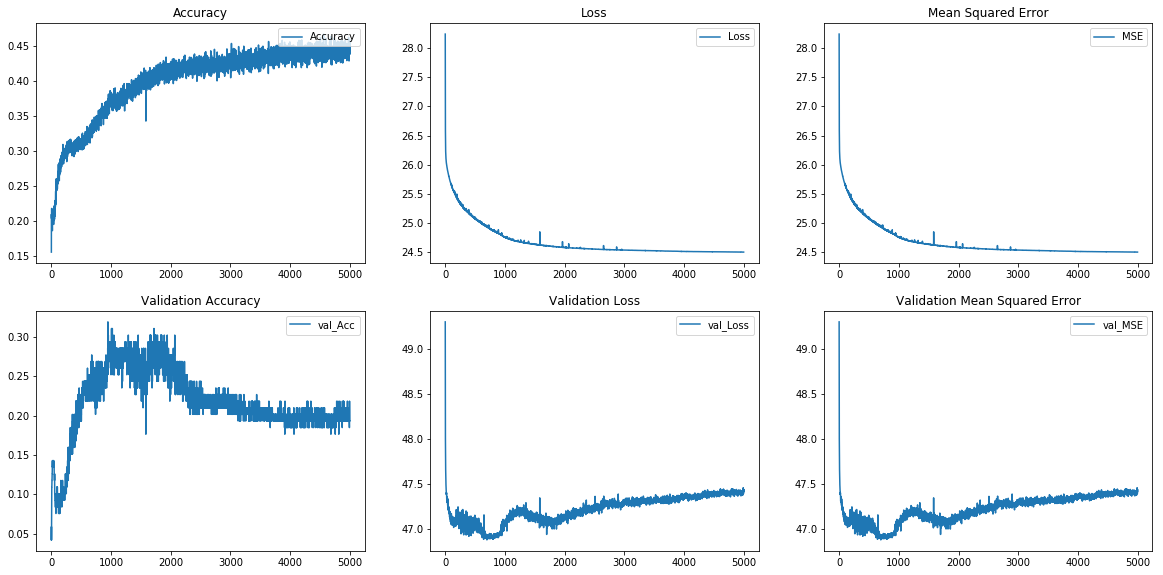

In [15]:
plt.figure(figsize=(20,15))
plt.subplot(331)
plt.plot(model_history.history['acc'] , label = 'Accuracy')
plt.legend(loc = 'upper right')
plt.title("Accuracy")

plt.subplot(332)
plt.plot(model_history.history['loss'] , label = 'Loss')
plt.legend(loc = 'upper right')
plt.title("Loss")

plt.subplot(333)
plt.plot(model_history.history['mean_squared_error'] , label = 'MSE')
plt.legend(loc = 'upper right')
plt.title("Mean Squared Error")

plt.subplot(334)
plt.plot(model_history.history['val_acc'] , label = 'val_Acc')
plt.legend(loc = 'upper right')
plt.title("Validation Accuracy")

plt.subplot(335)
plt.plot(model_history.history['val_loss'] , label = 'val_Loss')
plt.legend(loc = 'upper right')
plt.title("Validation Loss")

plt.subplot(336)
plt.plot(model_history.history['val_mean_squared_error'] , label = 'val_MSE')
plt.legend(loc = 'upper right')
plt.title("Validation Mean Squared Error")

plt.show()

In [12]:
# model = load_model('LSTM_512_128_10000.h5')

In [16]:
predicts = []
test_data = x_test.copy()
for (index, element) in enumerate(y_test):
    predict = model.predict(test_data, verbose = 0)
    predicts.append(predict[0])
    test_data = findNewXTest(test_data, predict[0])

In [17]:
def plot_graph(array1, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


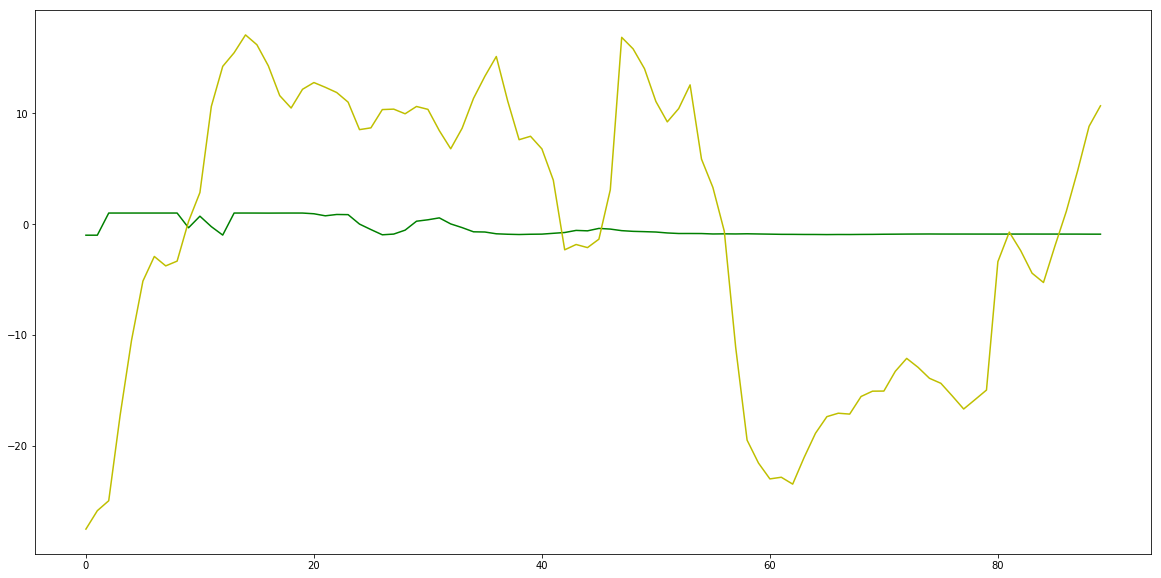

AOT


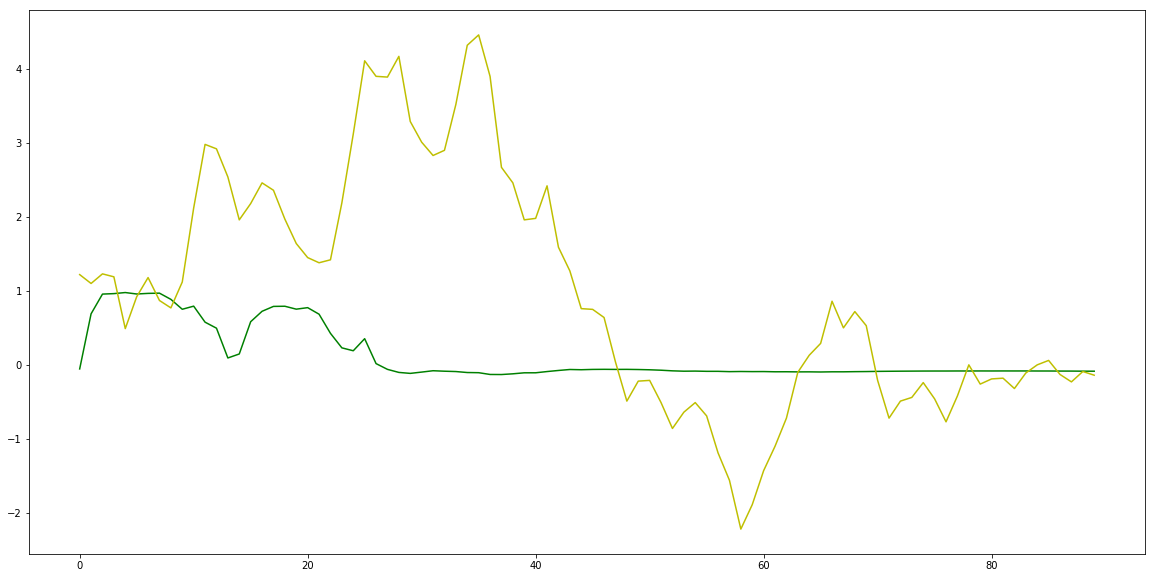

BANPU


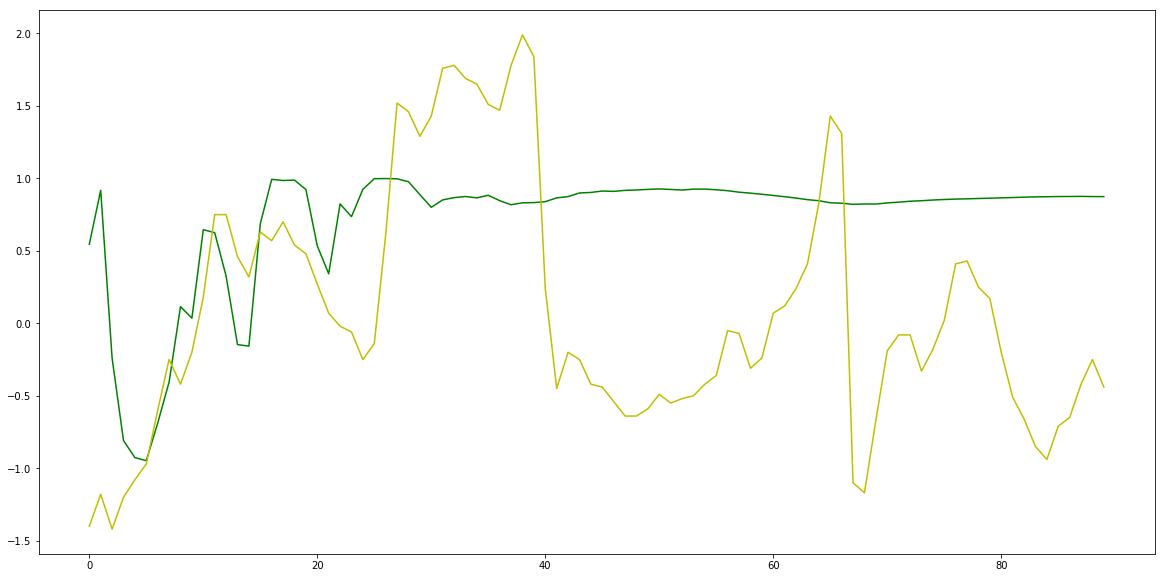

BBL


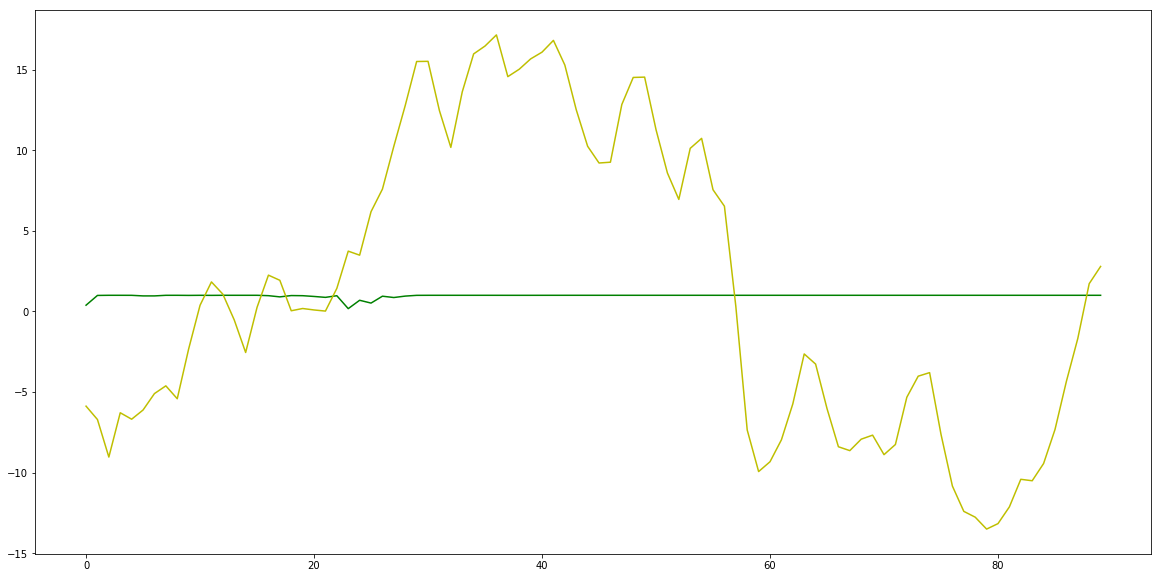

BCP


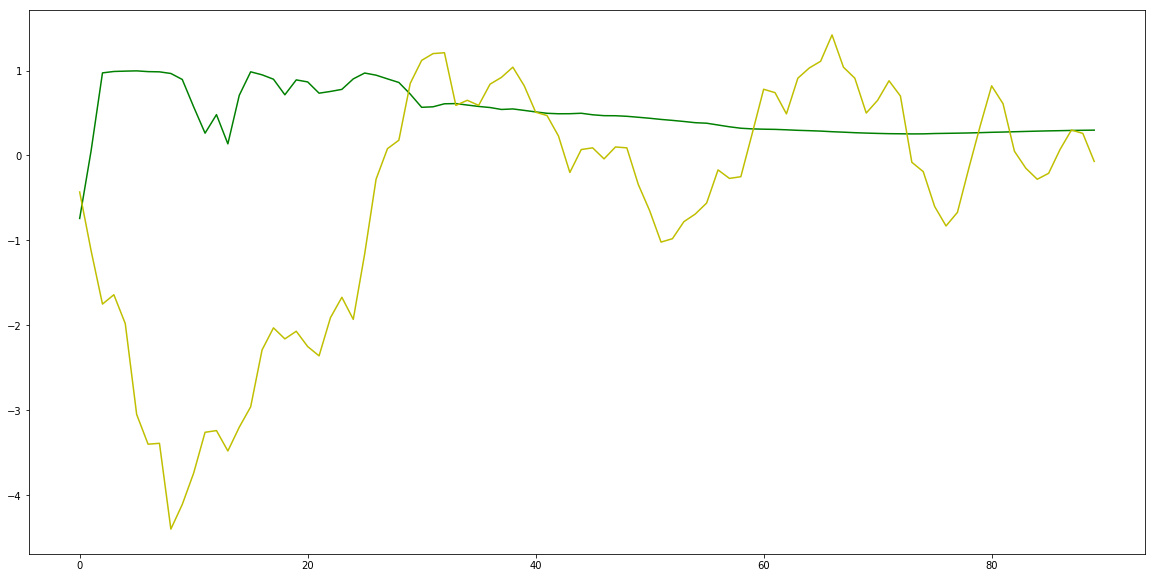

BDMS


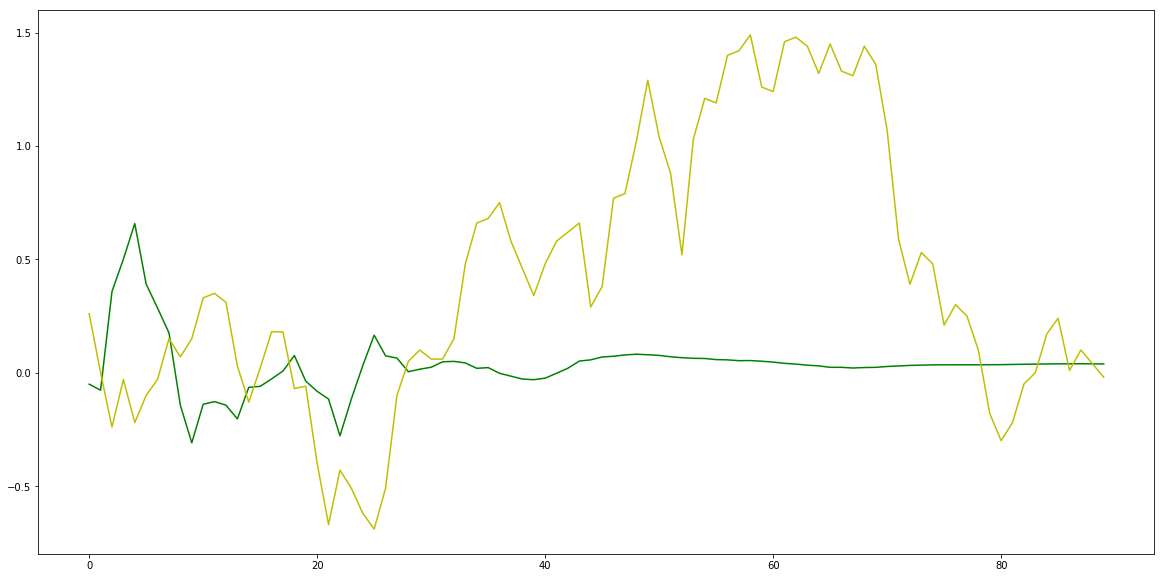

BEM


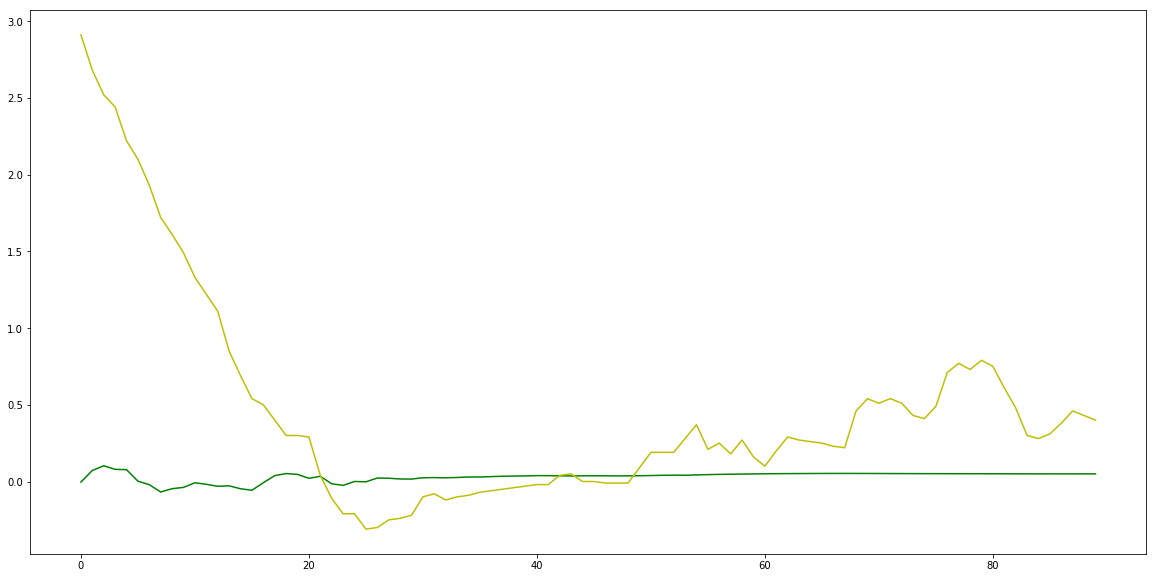

BH


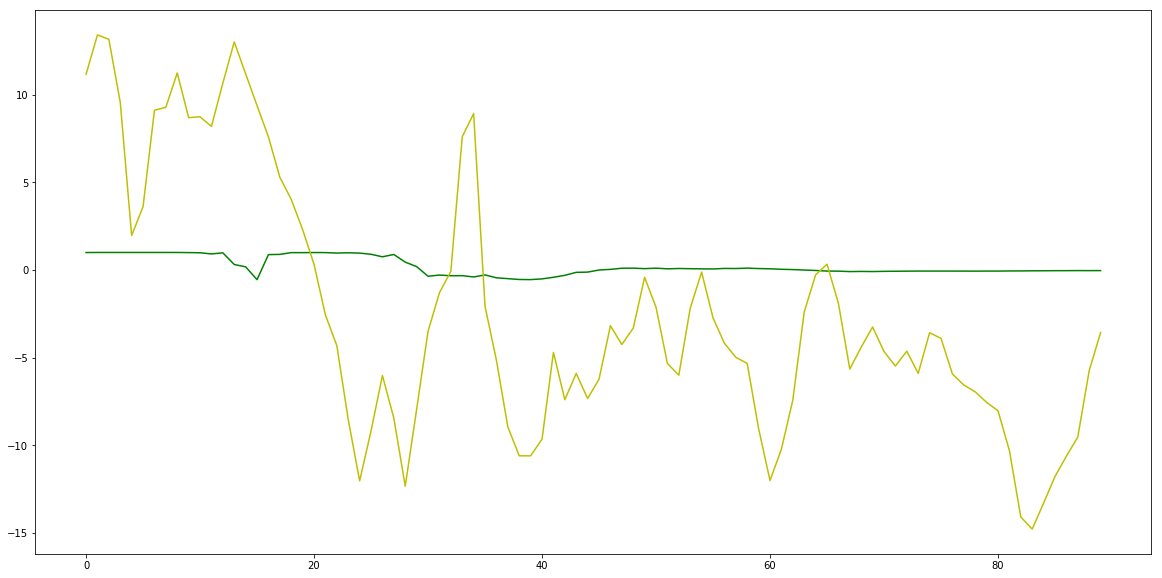

BJC


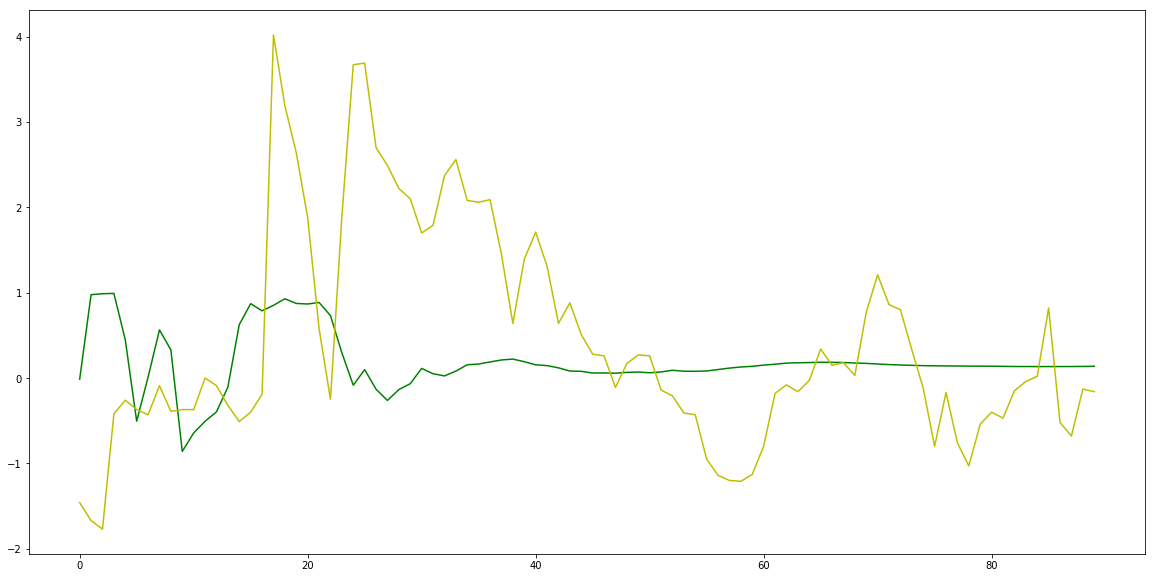

BTS


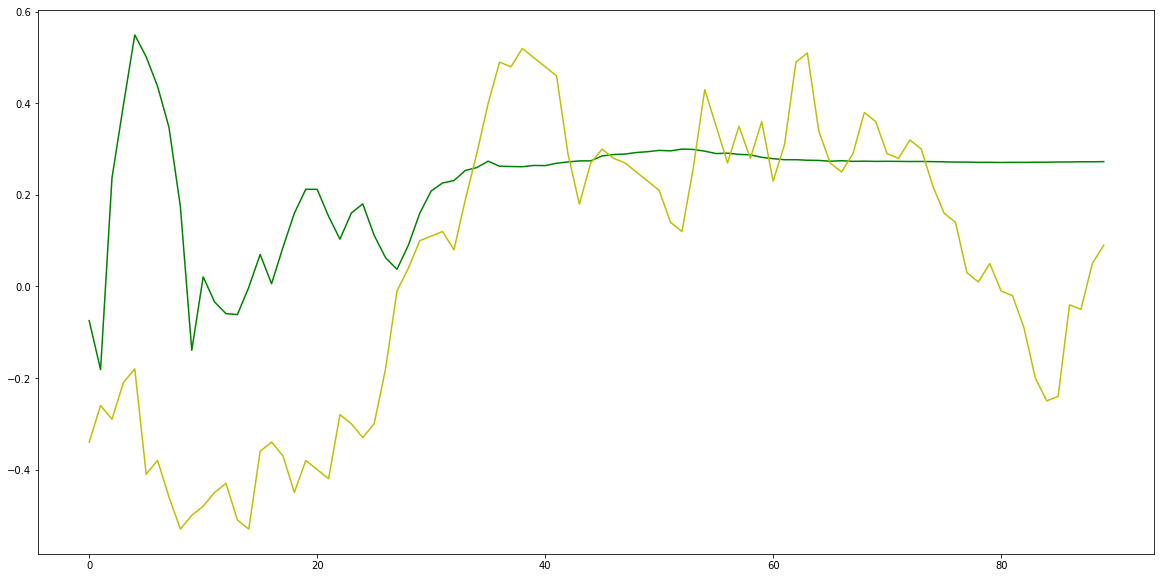

CENTEL


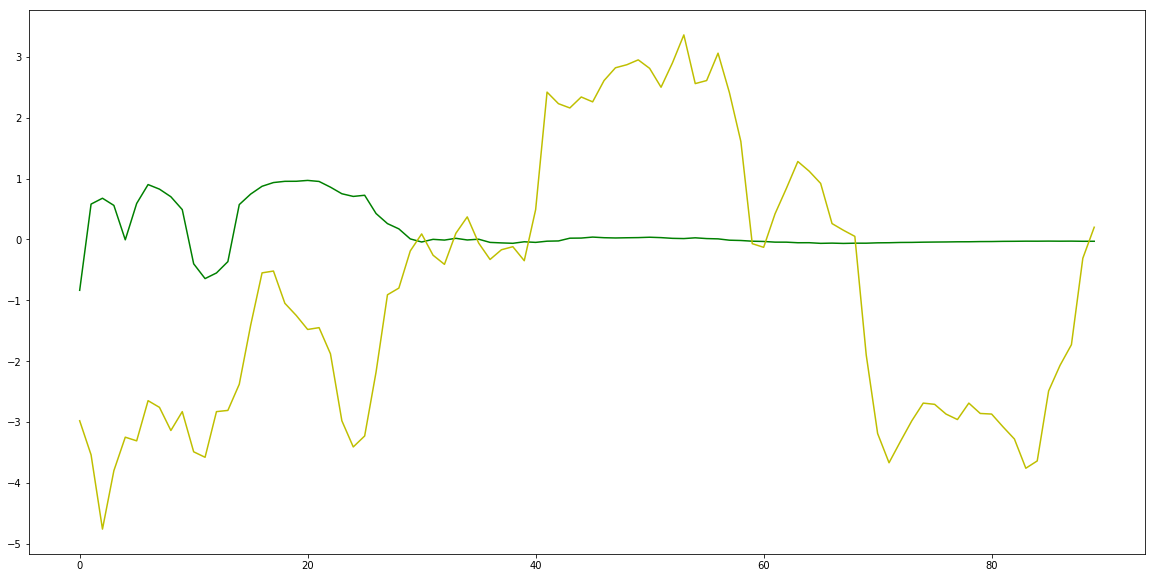

CPALL


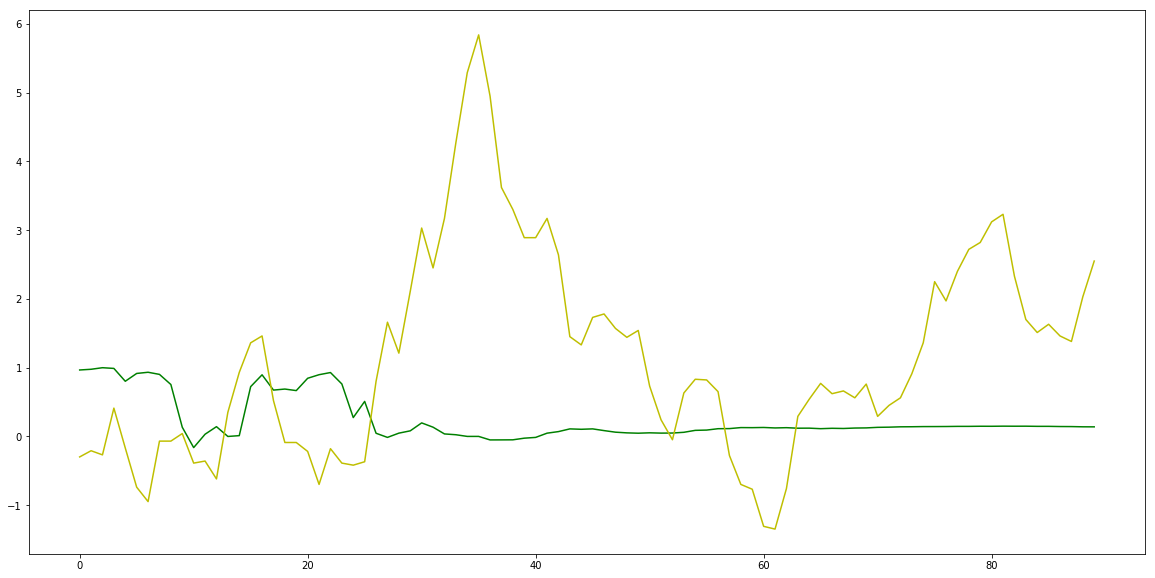

CPF


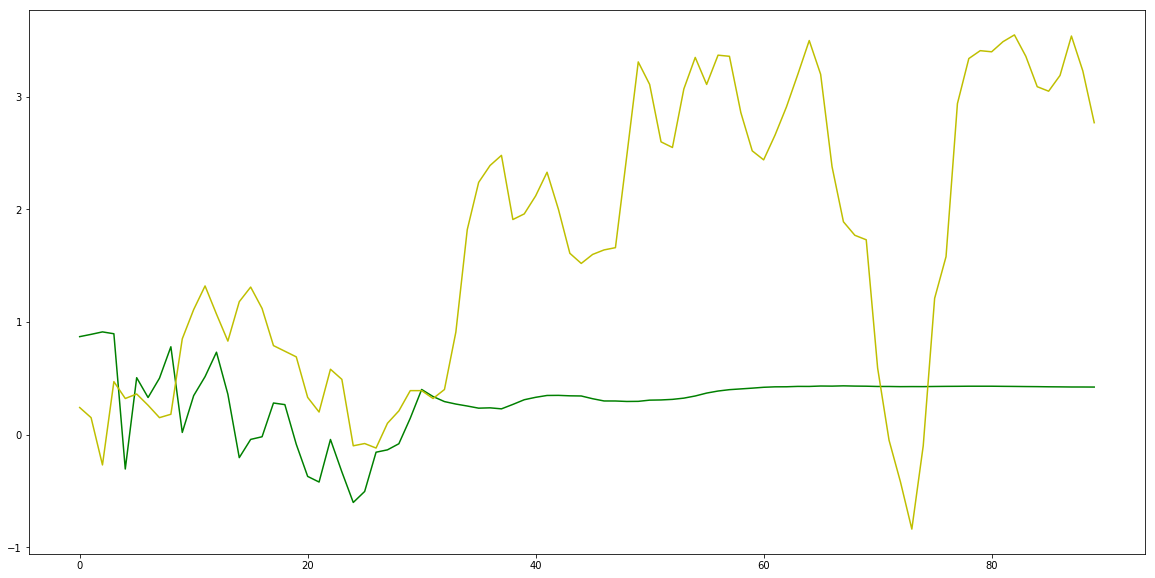

CPN


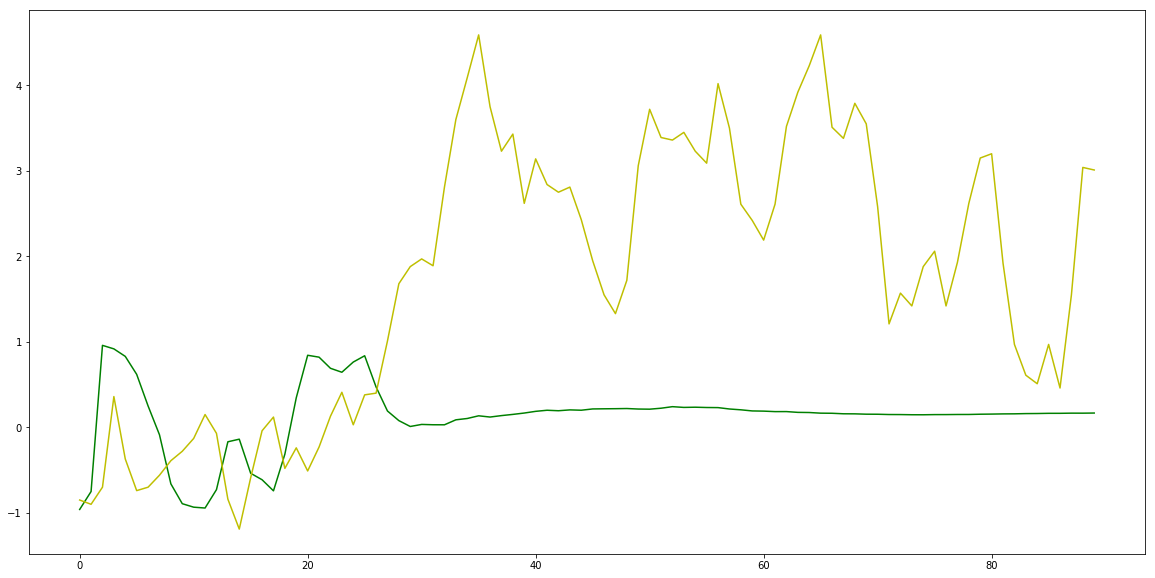

DTAC


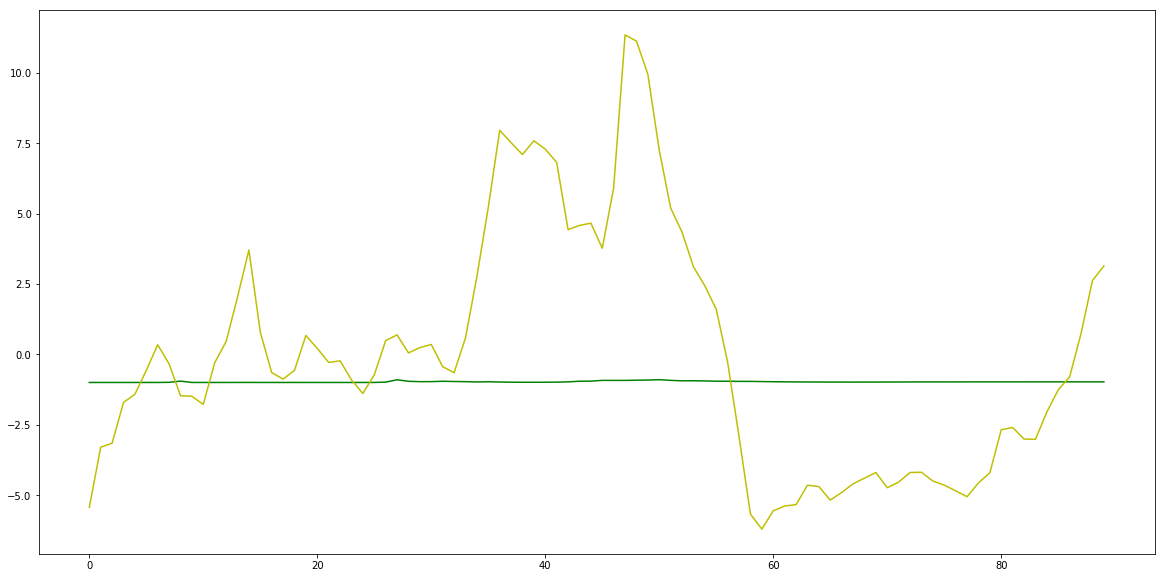

EGCO


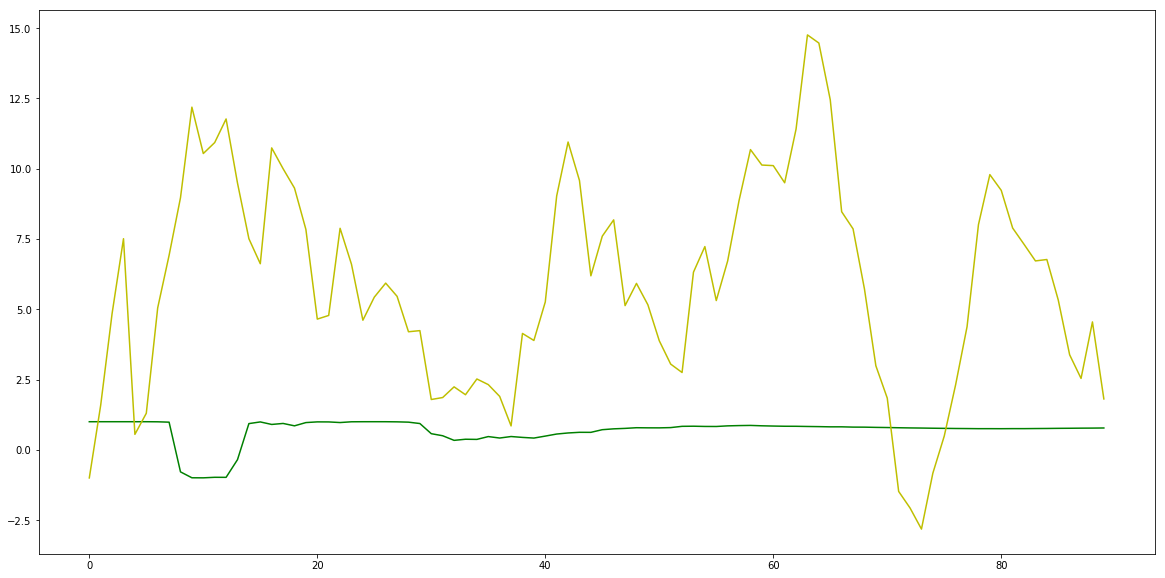

HMPRO


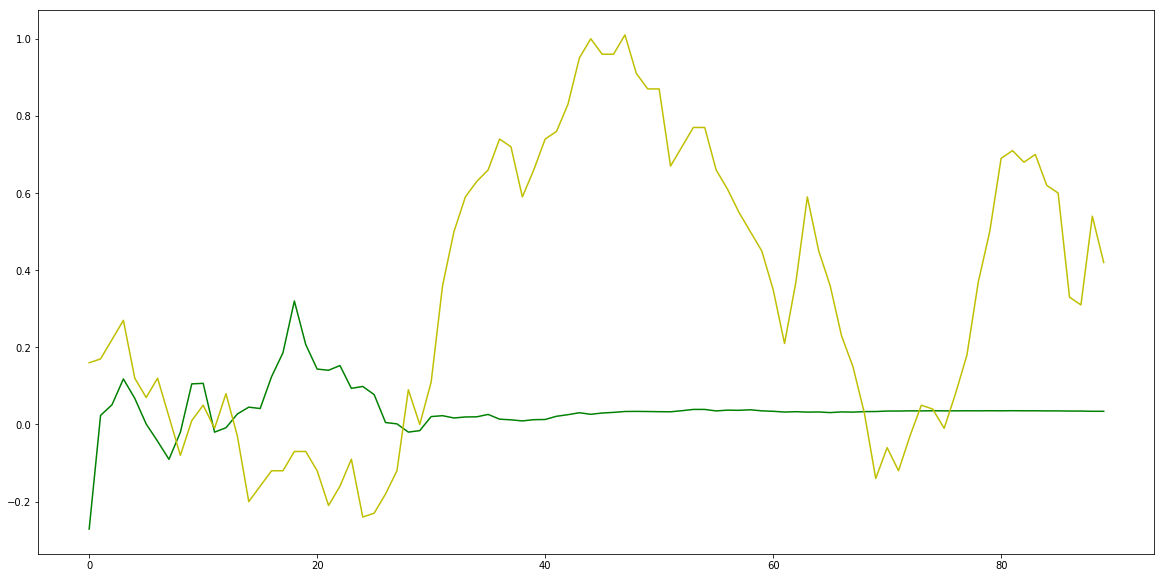

INTUCH


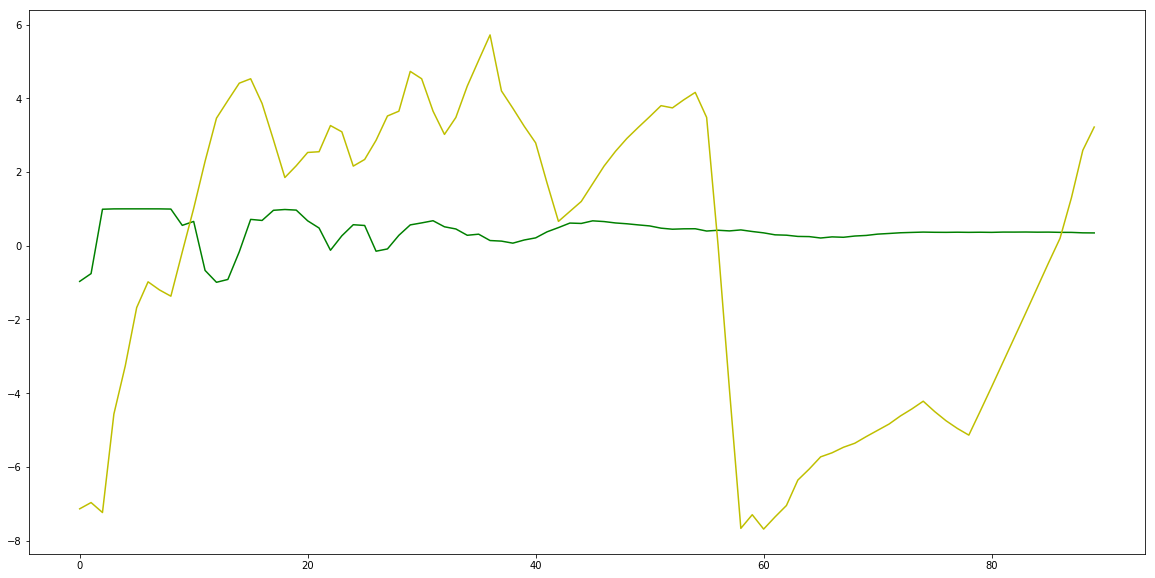

IRPC


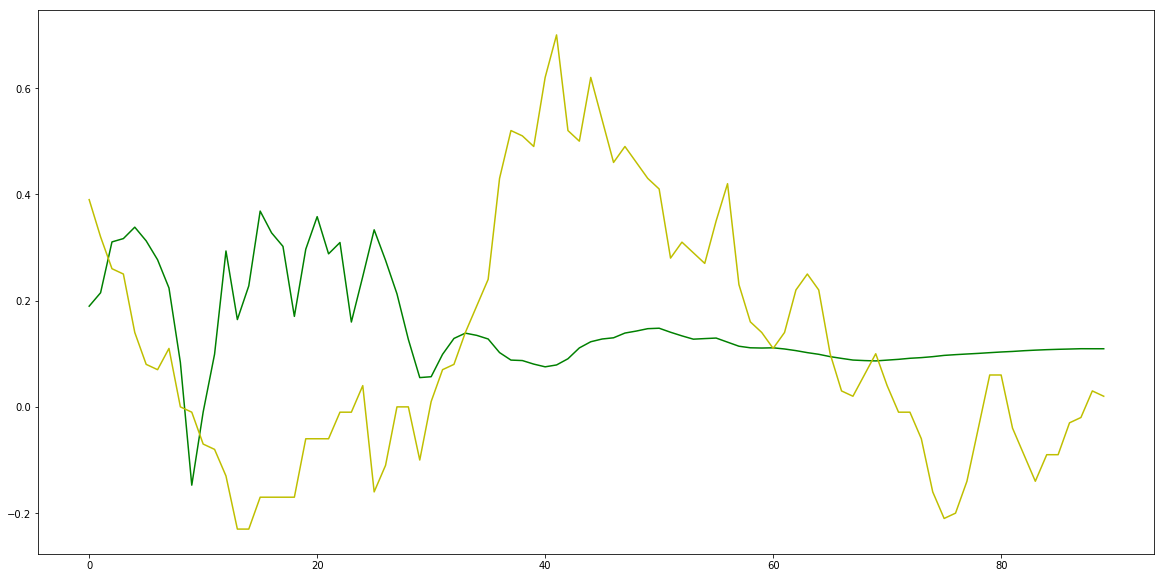

KBANK


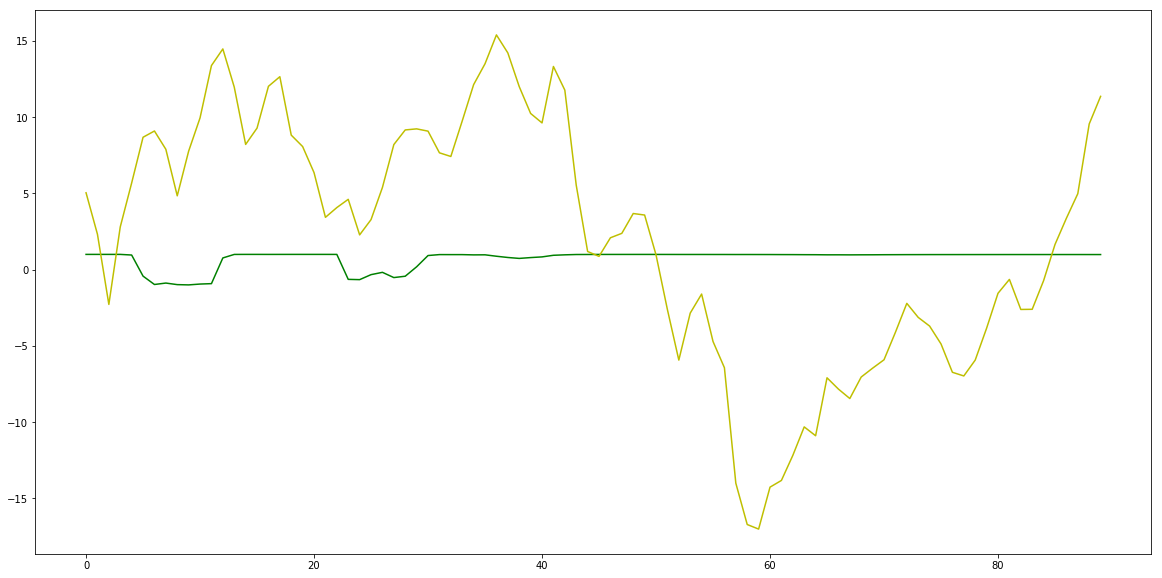

KCE


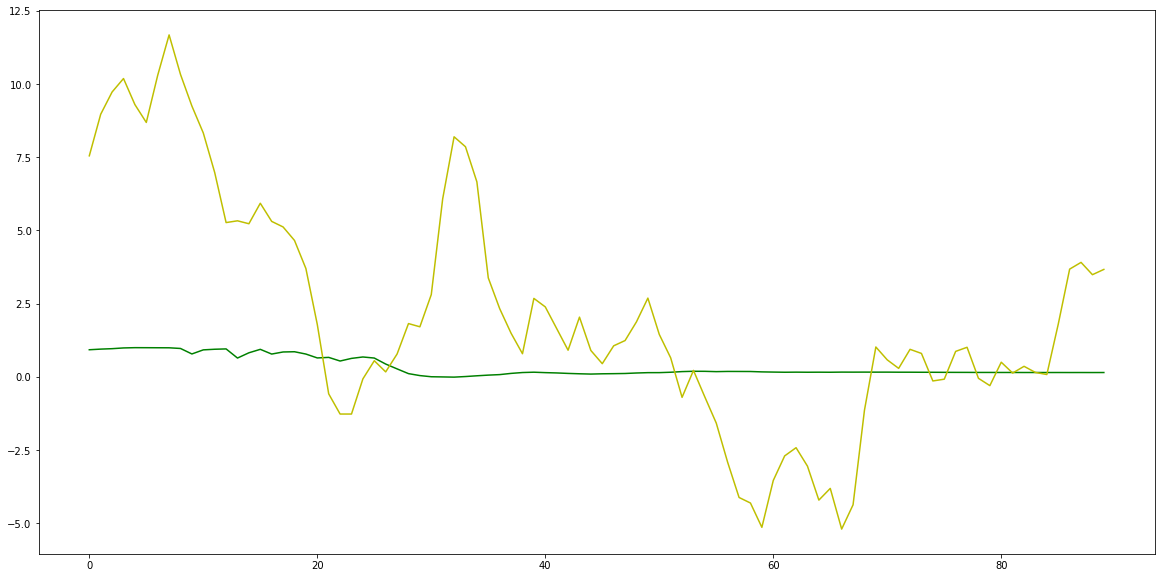

KKP


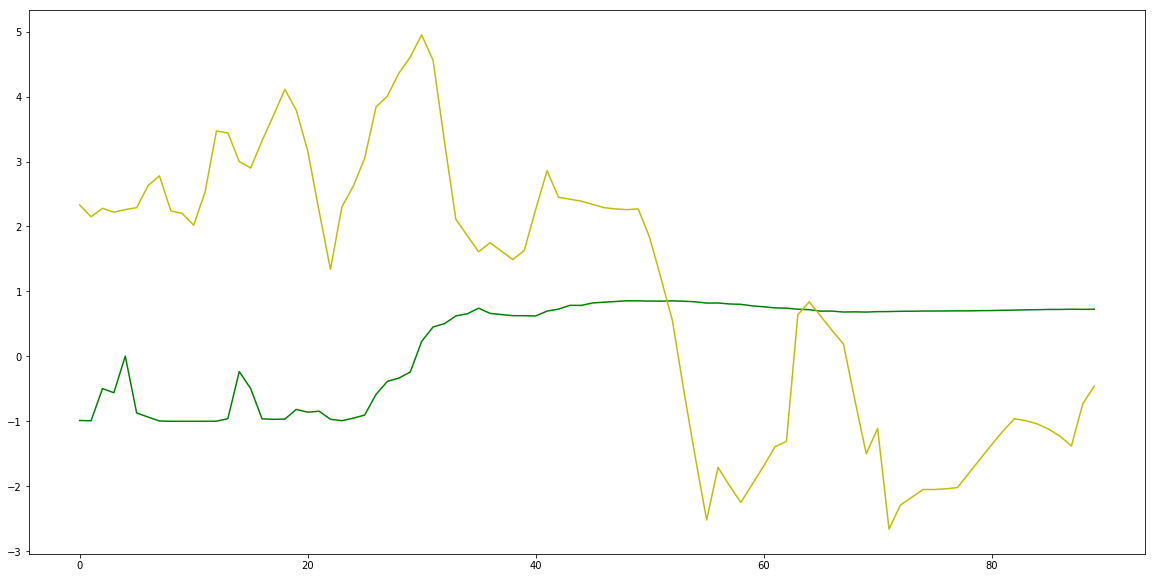

KTB


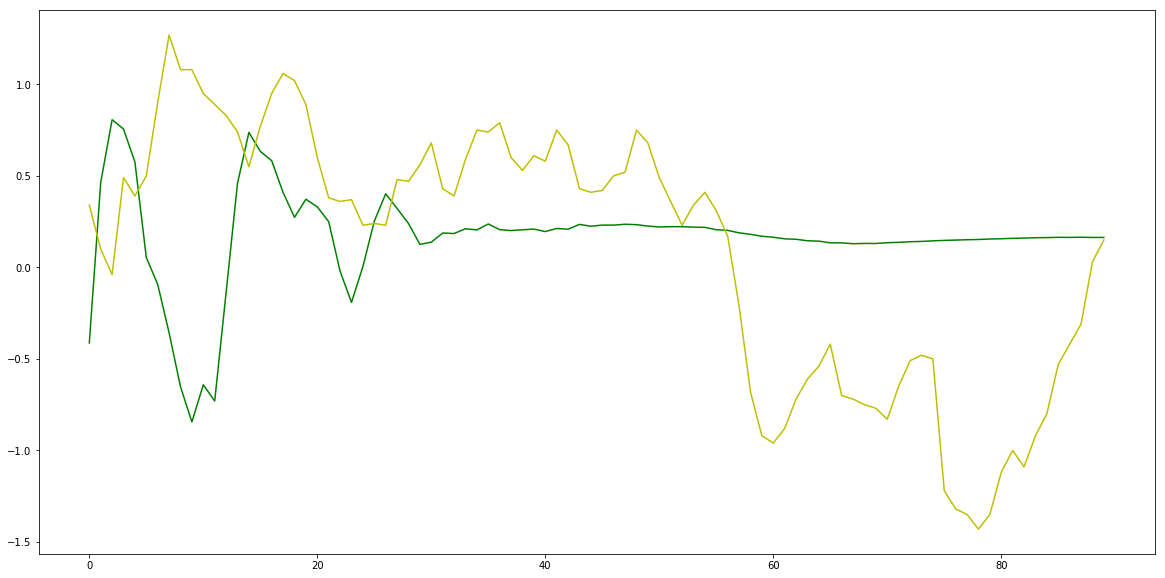

LH


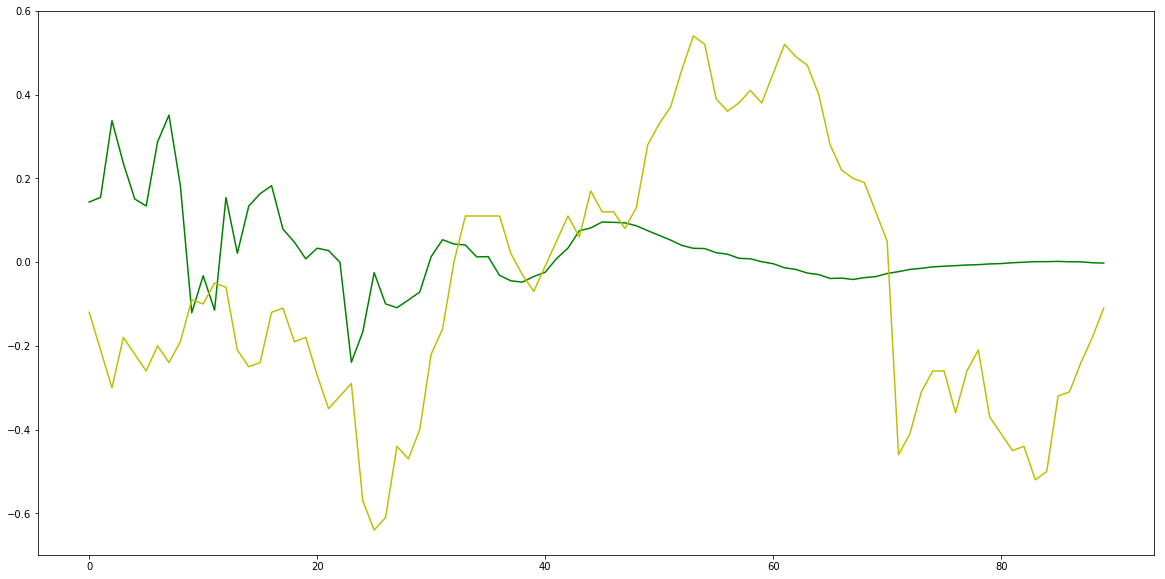

MINT


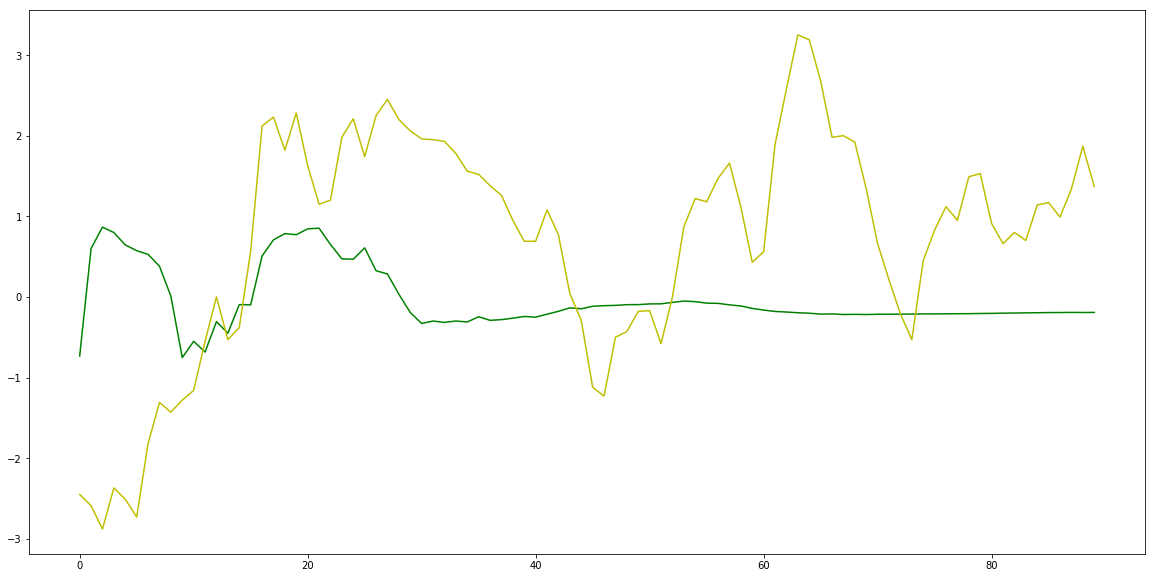

PTT


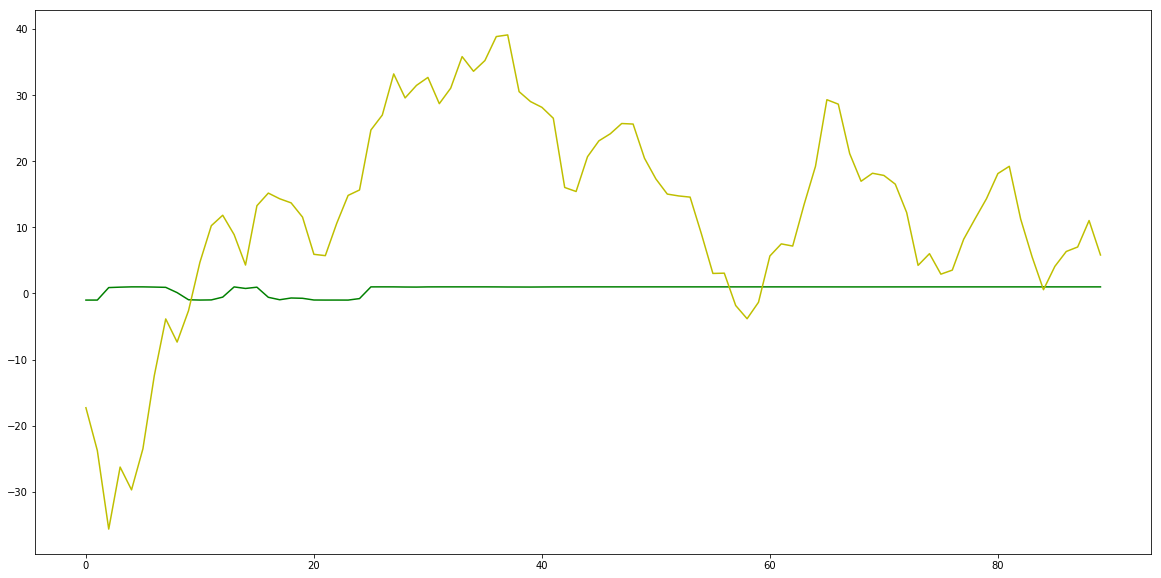

PTTEP


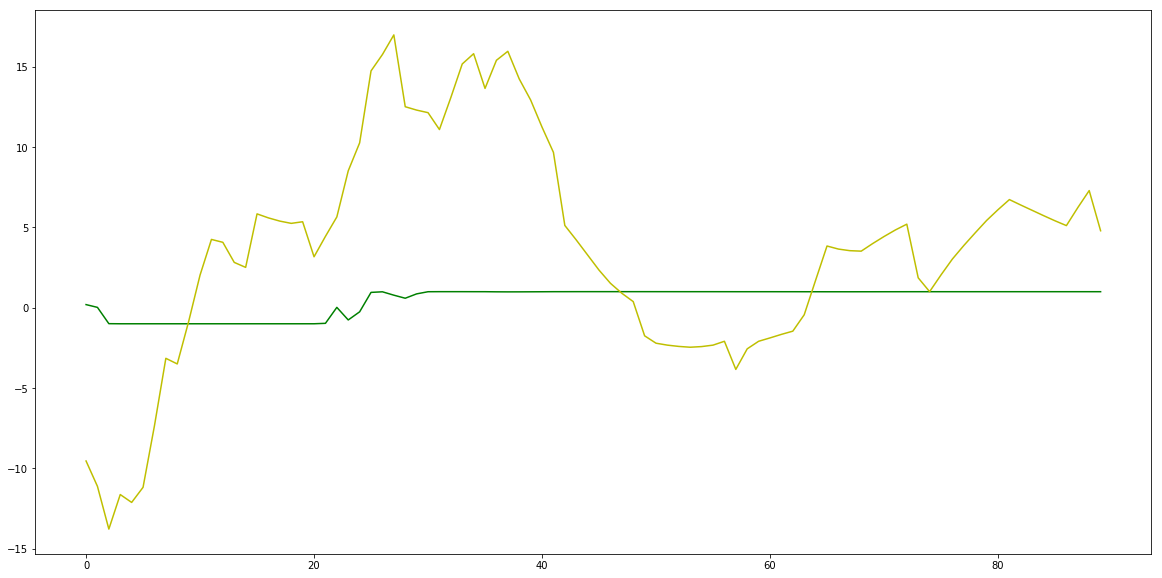

ROBINS


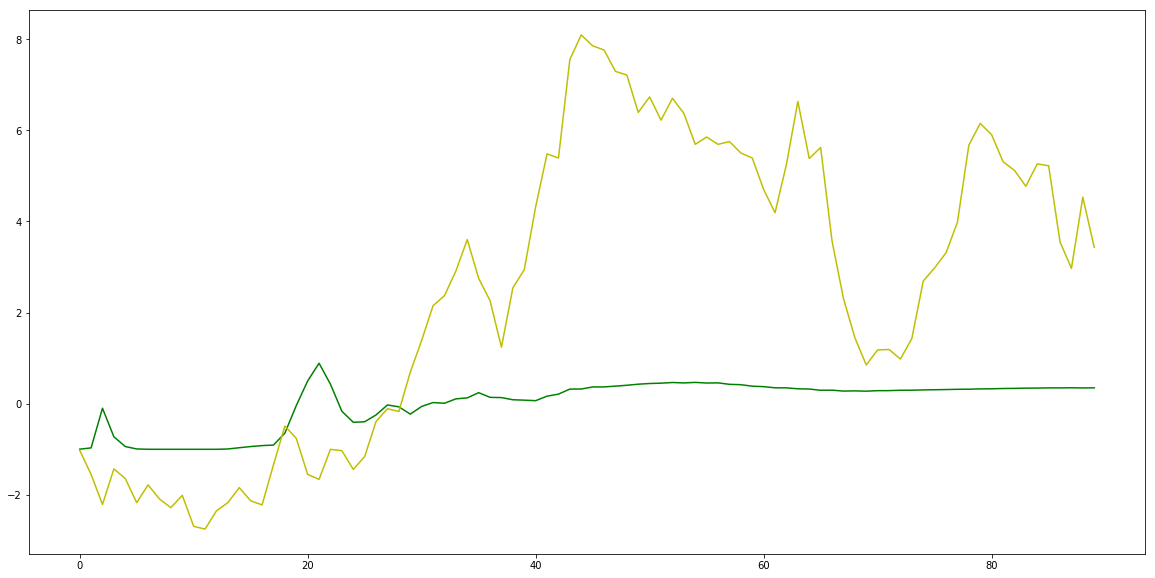

SCB


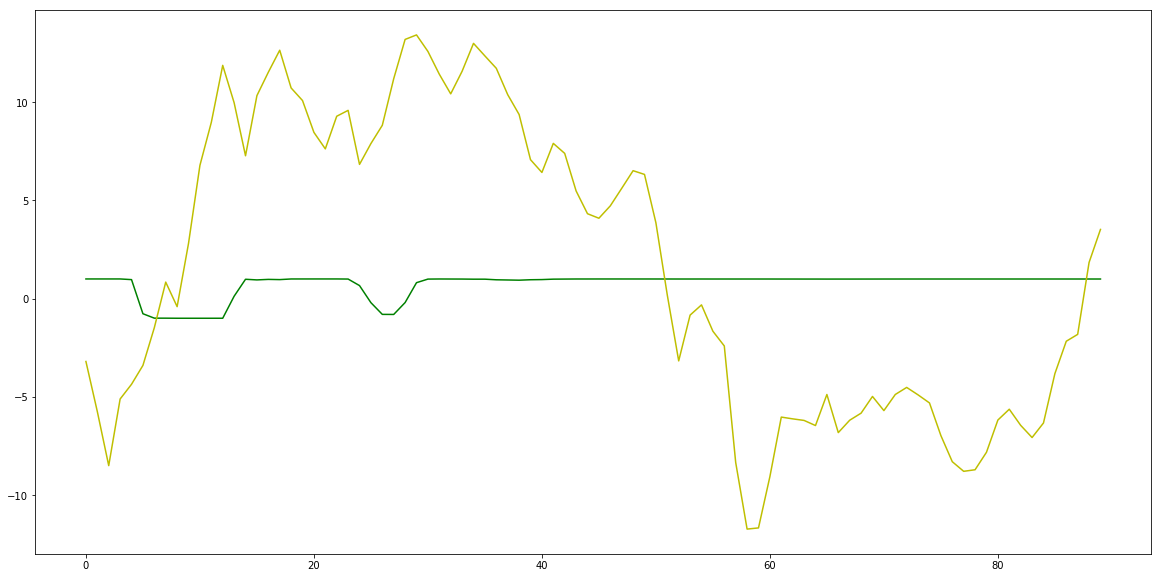

SCC


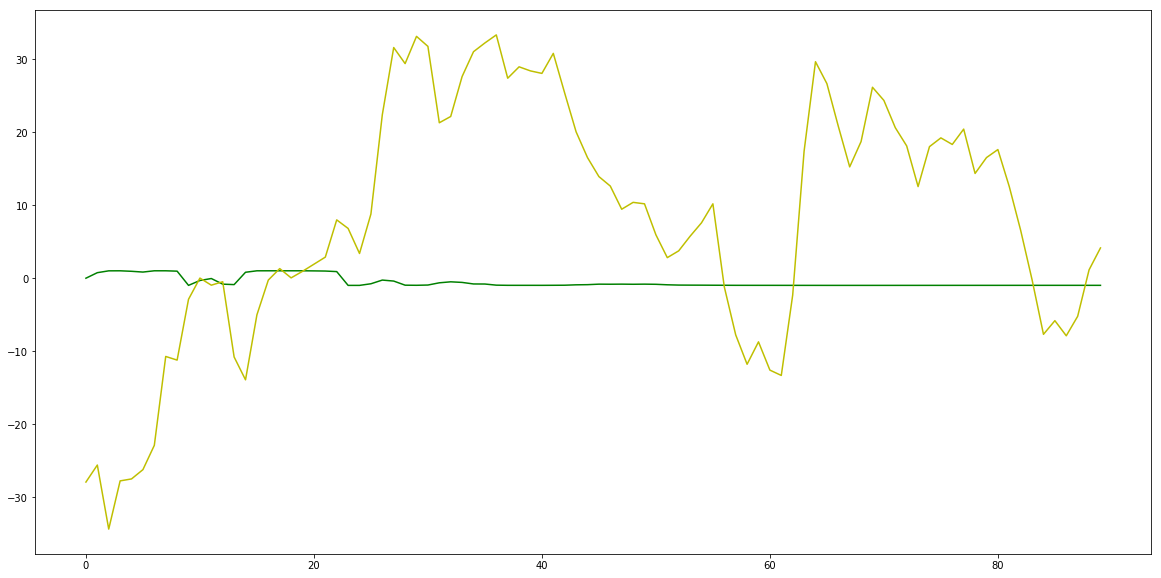

TCAP


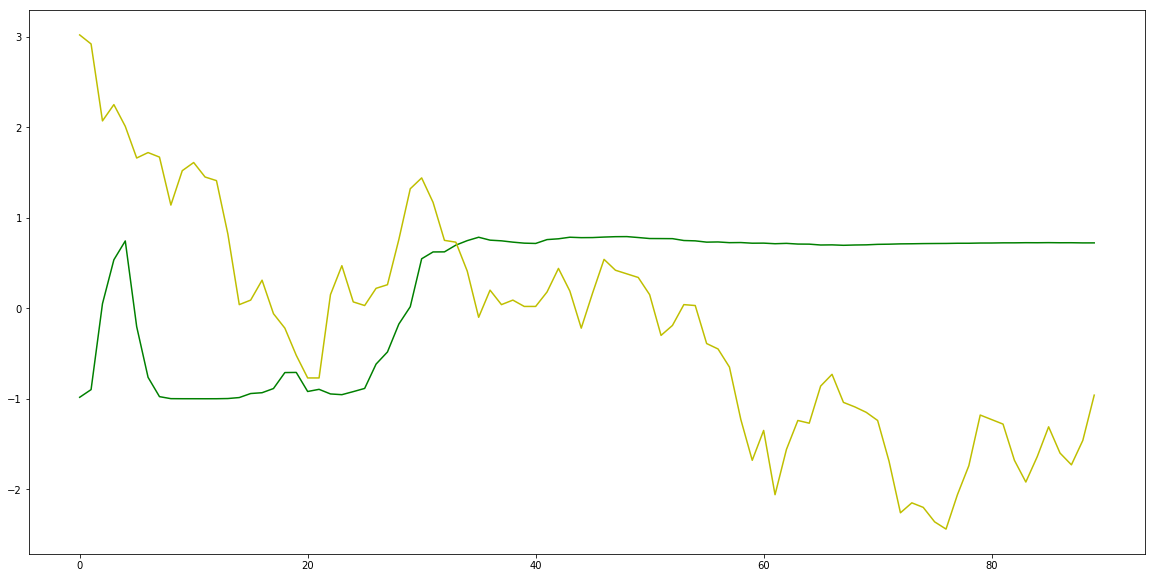

TISCO


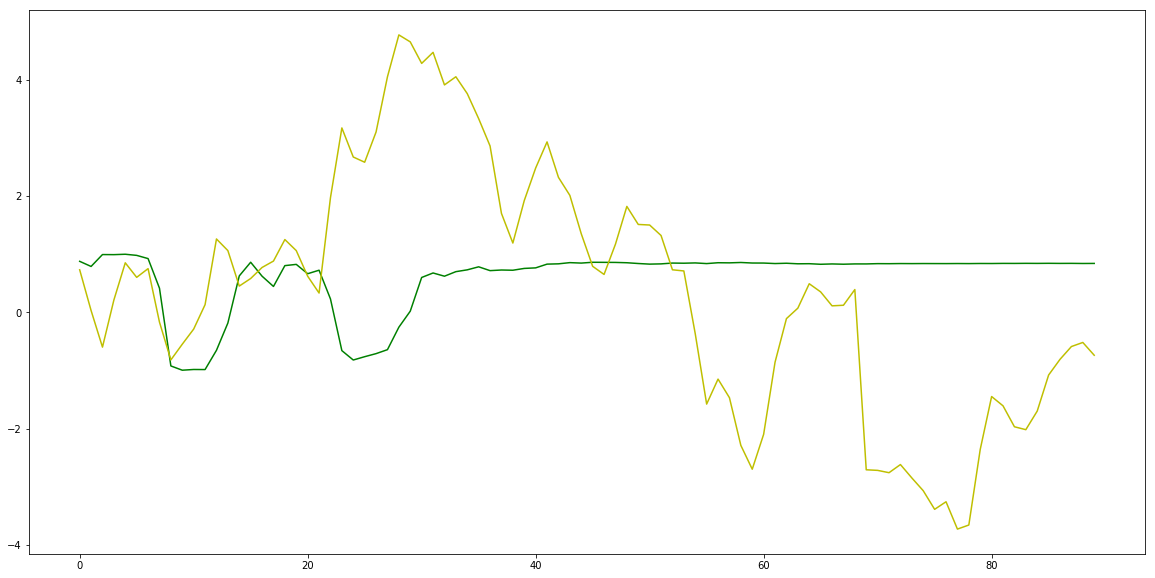

TMB


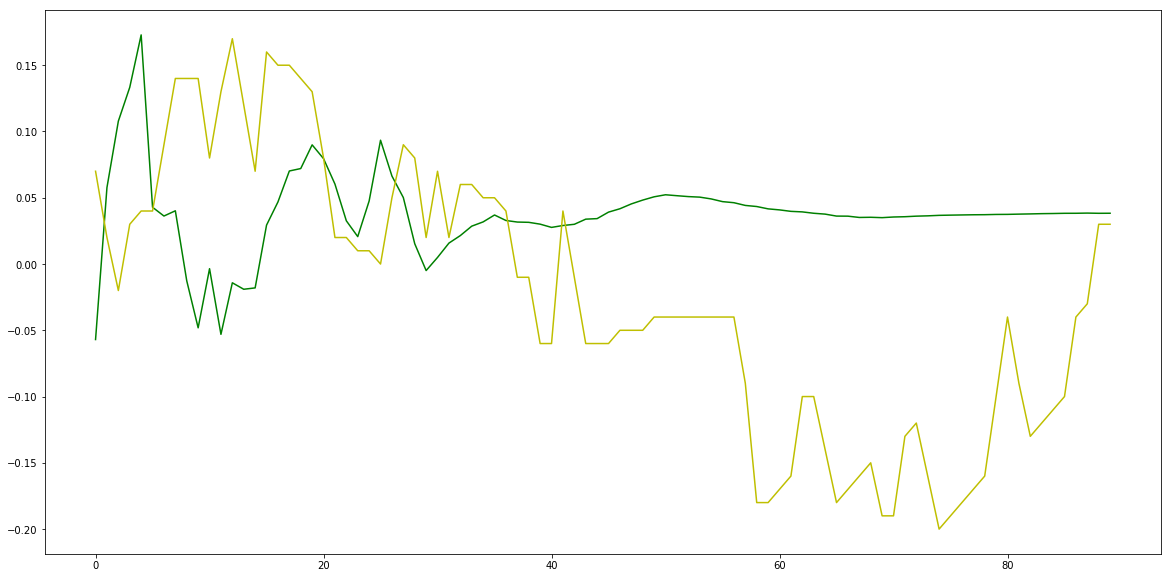

TOP


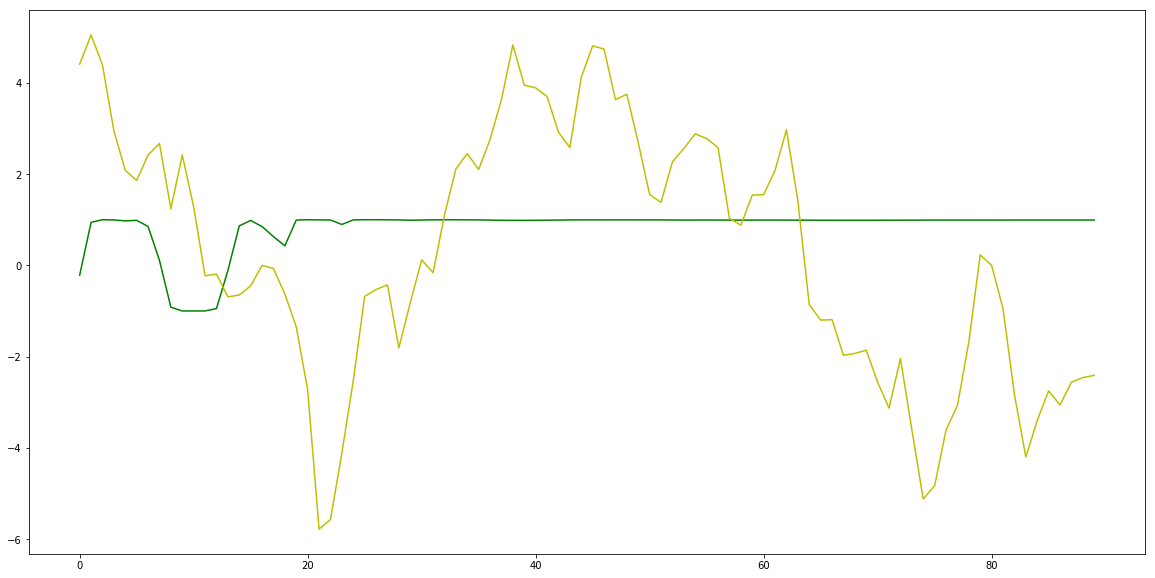

TRUE


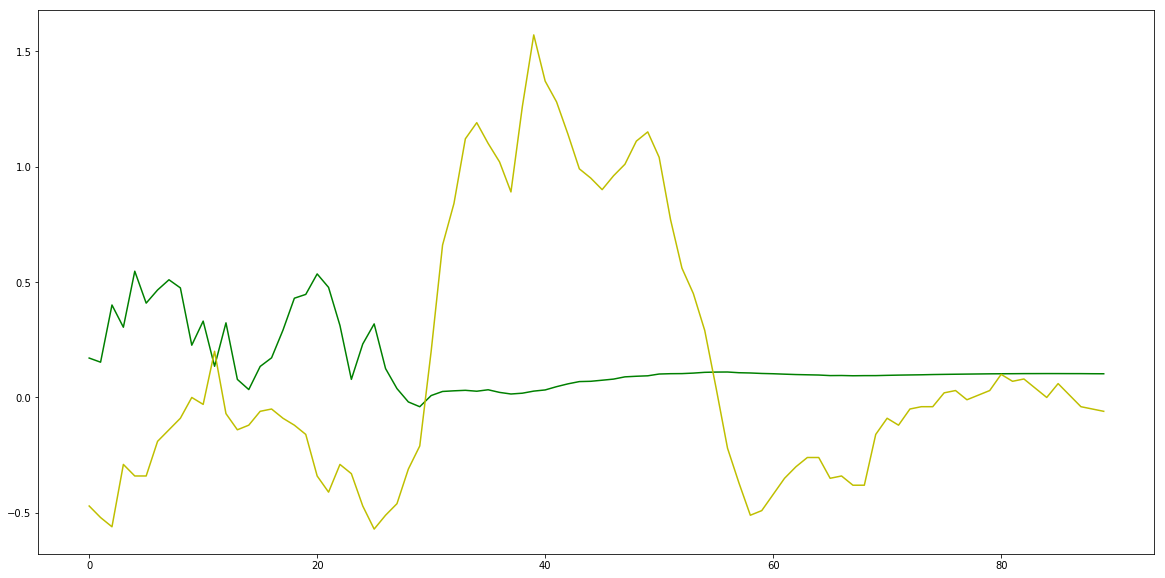

TU


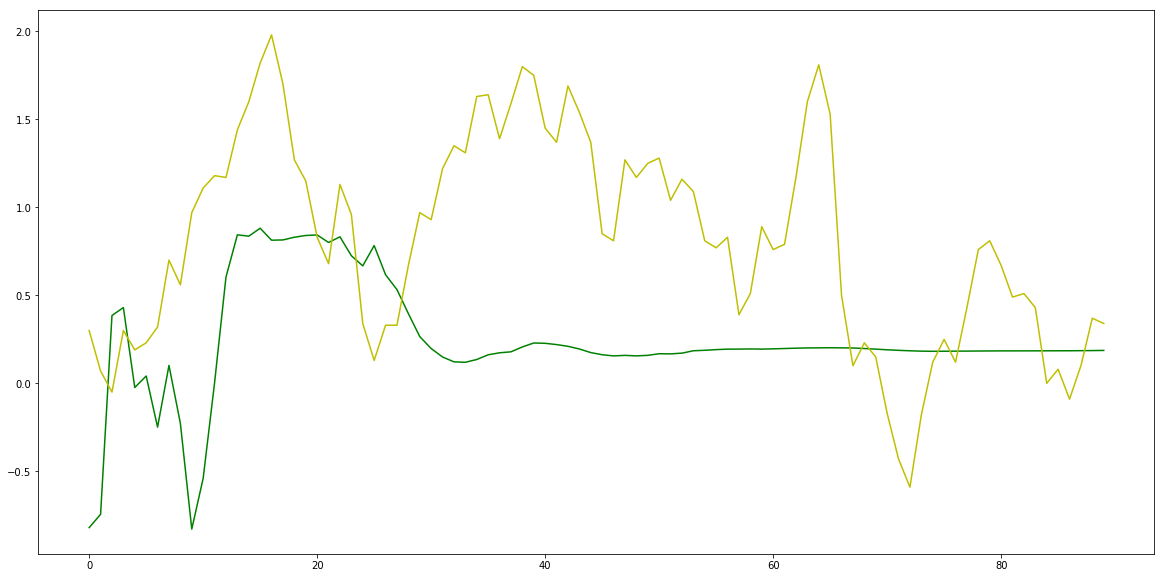

In [18]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[0: 90], i)
    data4 = get_data_from_nparray(y_test[0: 90], i)
    plot_graph(data1, data4)

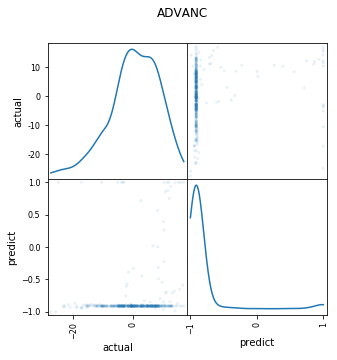

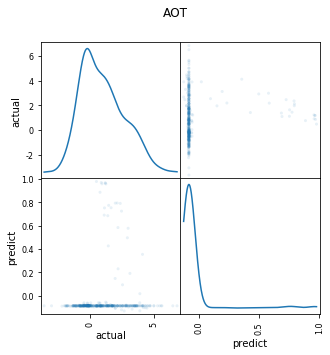

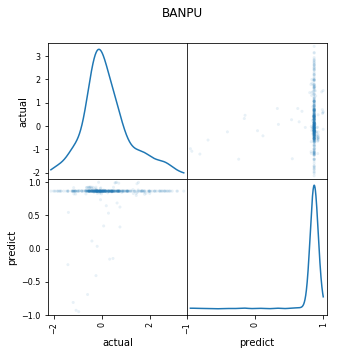

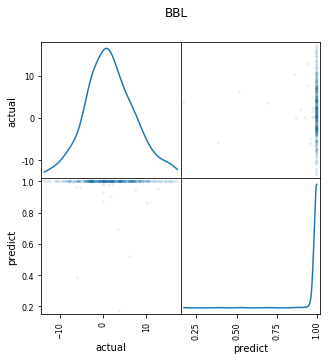

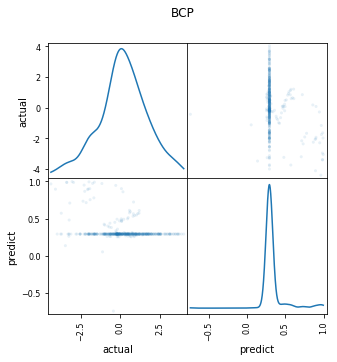

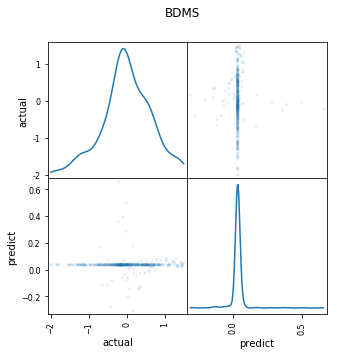

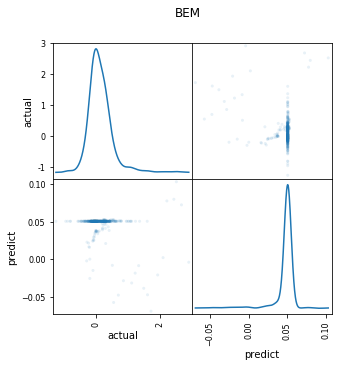

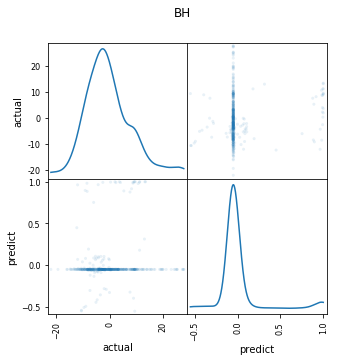

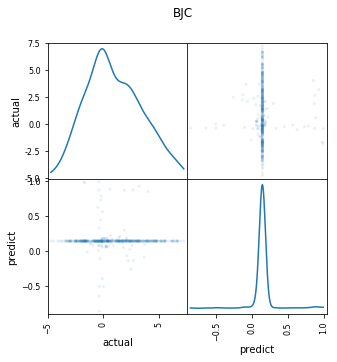

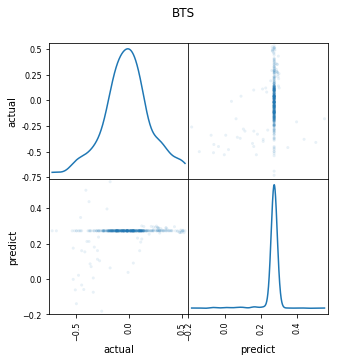

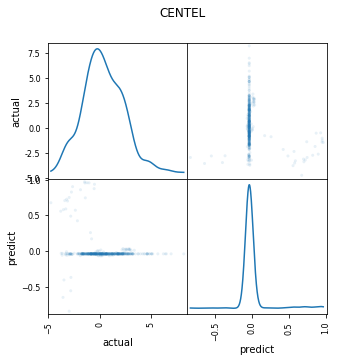

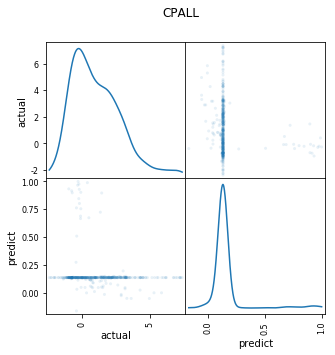

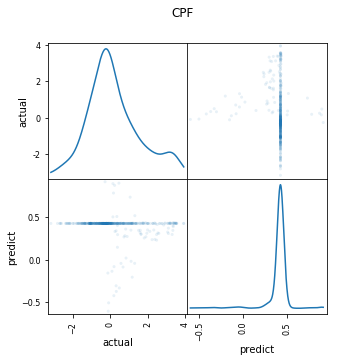

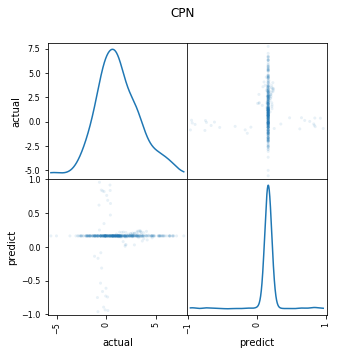

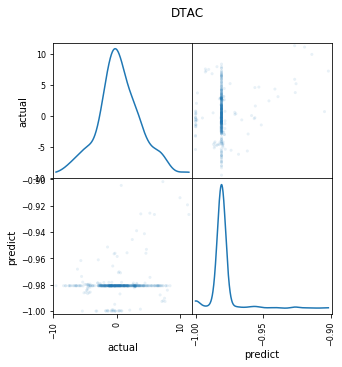

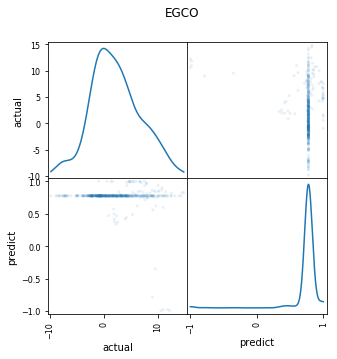

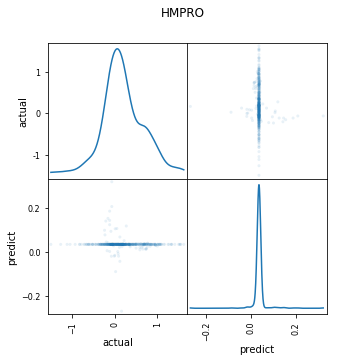

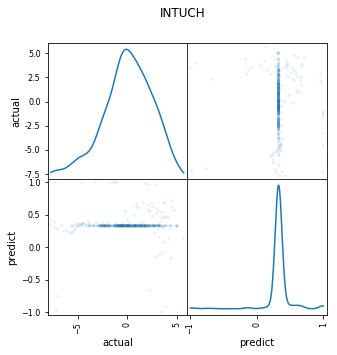

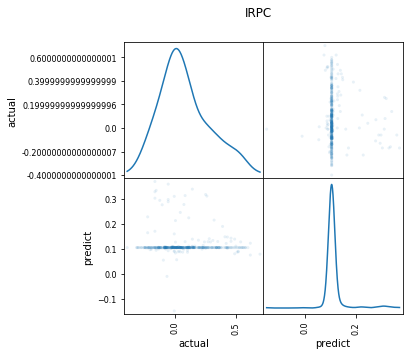

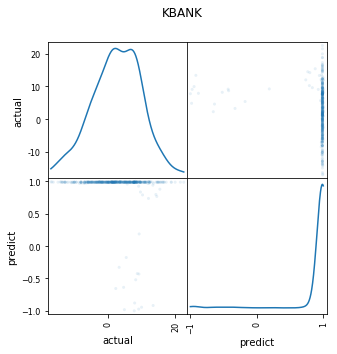

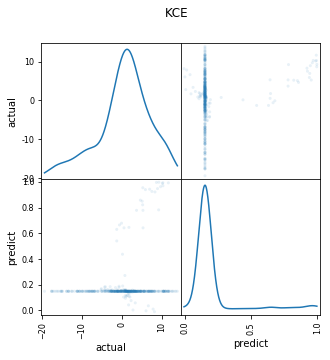

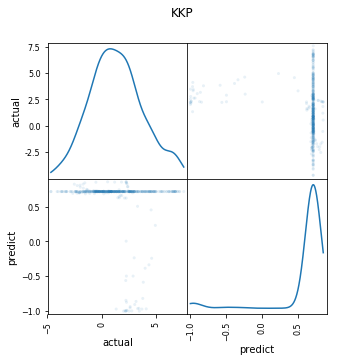

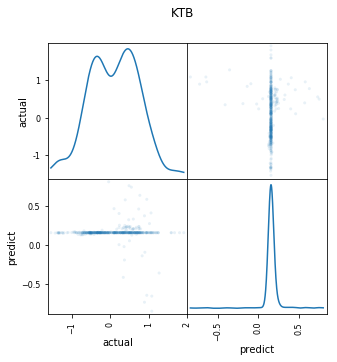

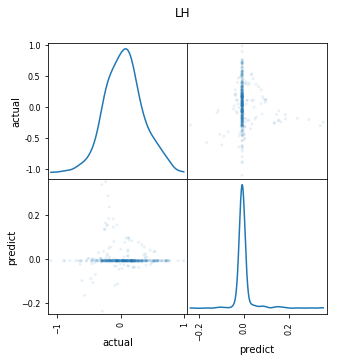

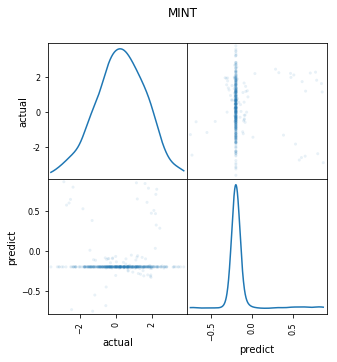

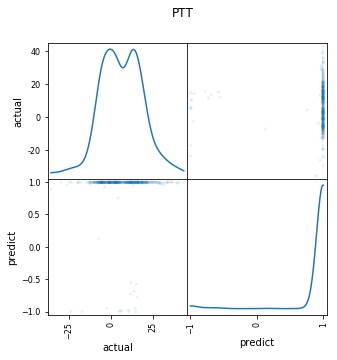

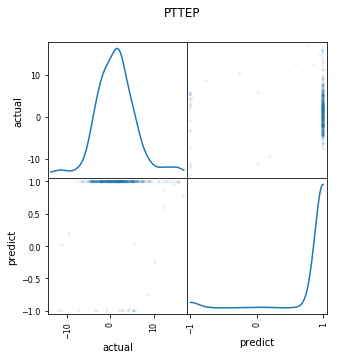

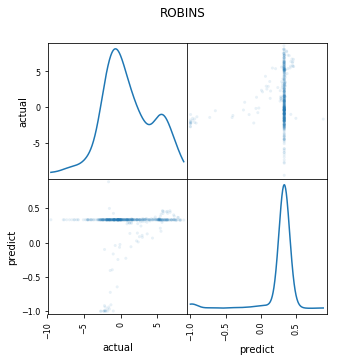

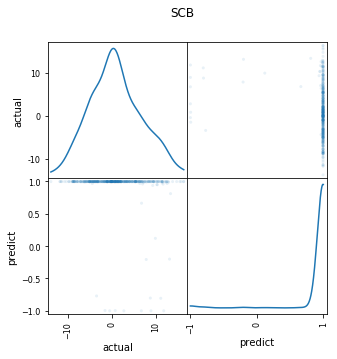

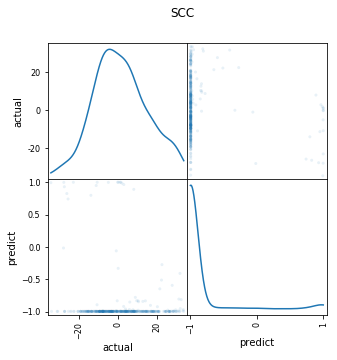

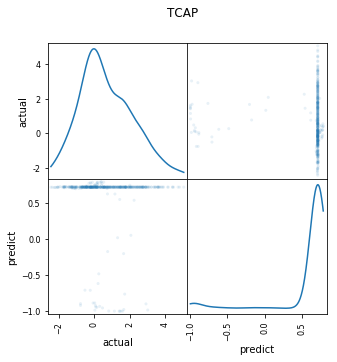

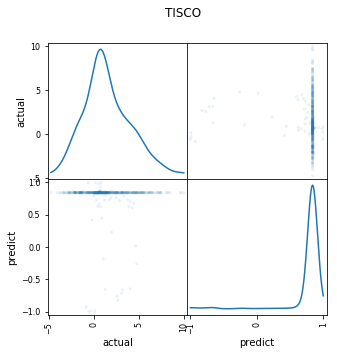

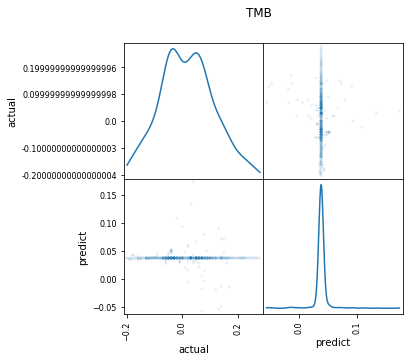

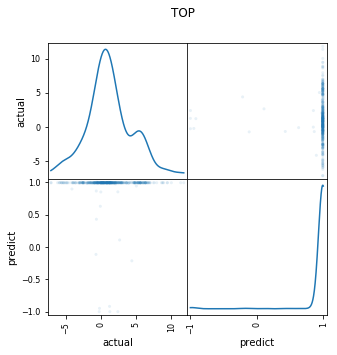

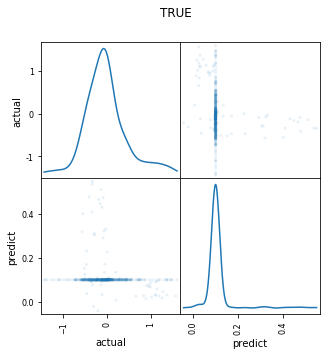

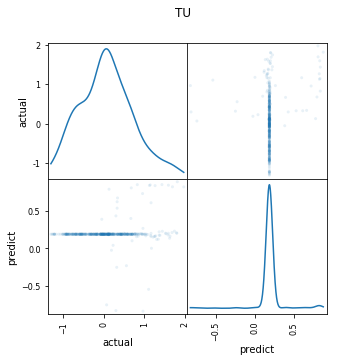

In [19]:
for i in range(len(SET50)):
    d = {'actual': get_data_from_nparray(y_test,i), 'predict': get_data_from_nparray(predicts,i)}
    df = pd.DataFrame(data=d)
    pd.plotting.scatter_matrix(df, diagonal='kde', alpha=0.1,figsize=(5,5))
    plt.suptitle(SET50[i])
    plt.show()